In [1]:
%load_ext autotime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import pandas as pd 
import os

import opendiff.materials as mat
import opendiff.solver as solver
import opendiff.perturbation as pert
from opendiff import set_log_level, log_level

import grid_post_process as pp

solver.init_slepc()
set_log_level(log_level.warning)

time: 1.37 s (started: 2022-11-24 08:42:44 +01:00)


# Material creation

In [2]:
fuel1 = [[1.4360, 0.0095042, 0.0058708, 1, 0., 0.017754, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3635, 0.0750058, 0.0960670, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel2 = [[1.4366, 0.0096785, 0.0061908, 1, 0., 0.017621, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3636, 0.078436, 0.1035800, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl = [[1.32, 0.0026562, 0, 1, 0., 0.023106, 202 * 1.60218e-19 * 1e6, 2.4],
        [0.2772, 0.071596, 0, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel3 = [[1.4389, 0.010363, 0.0074527, 1, 0., 0.017101, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3638, 0.091408, 0.1323600, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel4 = [[1.4381, 0.0100030, 0.0061908, 1, 0., 0.017290, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3665, 0.0848280, 0.103580, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel5 = [[1.4385, 0.0101320, 0.0064285, 1, 0., 0.017192, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3665, 0.087314, 0.109110, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel6 = [[1.4389, 0.010165, 0.0061908, 1, 0., 0.017125, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3679, 0.088024, 0.1035800, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel7 = [[1.4393, 0.010294, 0.0064285, 1, 0., 0.017027, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3680, 0.09051, 0.1091100, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
void = [[1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4],
        [1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
all_mat = [fuel1, fuel2, fuel3, fuel4, fuel5, fuel6, fuel7, refl, void]
mat_names = ["fuel1", "fuel2", "fuel3", "fuel4", "fuel5", "fuel6", "fuel7", "refl", "void"]
reac_names = ["D", "SIGA", "NU_SIGF", "CHI", "1", "2", "EFISS", "NU"]

mat_lib = mat.Materials(all_mat, mat_names, reac_names)

print(r"Material & Group (g) & $D_{g}$ & $\Sigma_{a,g}$ & $\nu \Sigma_{f,g}$ & $\Sigma_{1 \rigtarrow 2}$  \\ \hline")
for name, values_2g in zip(mat_names, all_mat):
    for i, values in enumerate(values_2g):
        print(f"{name} & {i+1} & {values[0]} & {values[1]} & {values[2]} & {values[5]} \\\ \hline")

Material & Group (g) & $D_{g}$ & $\Sigma_{a,g}$ & $\nu \Sigma_{f,g}$ & $\Sigma_{1 \rigtarrow 2}$  \\ \hline
fuel1 & 1 & 1.436 & 0.0095042 & 0.0058708 & 0.017754 \\ \hline
fuel1 & 2 & 0.3635 & 0.0750058 & 0.096067 & 0.0 \\ \hline
fuel2 & 1 & 1.4366 & 0.0096785 & 0.0061908 & 0.017621 \\ \hline
fuel2 & 2 & 0.3636 & 0.078436 & 0.10358 & 0.0 \\ \hline
fuel3 & 1 & 1.4389 & 0.010363 & 0.0074527 & 0.017101 \\ \hline
fuel3 & 2 & 0.3638 & 0.091408 & 0.13236 & 0.0 \\ \hline
fuel4 & 1 & 1.4381 & 0.010003 & 0.0061908 & 0.01729 \\ \hline
fuel4 & 2 & 0.3665 & 0.084828 & 0.10358 & 0.0 \\ \hline
fuel5 & 1 & 1.4385 & 0.010132 & 0.0064285 & 0.017192 \\ \hline
fuel5 & 2 & 0.3665 & 0.087314 & 0.10911 & 0.0 \\ \hline
fuel6 & 1 & 1.4389 & 0.010165 & 0.0061908 & 0.017125 \\ \hline
fuel6 & 2 & 0.3679 & 0.088024 & 0.10358 & 0.0 \\ \hline
fuel7 & 1 & 1.4393 & 0.010294 & 0.0064285 & 0.017027 \\ \hline
fuel7 & 2 & 0.368 & 0.09051 & 0.10911 & 0.0 \\ \hline
refl & 1 & 1.32 & 0.0026562 & 0 & 0.023106 \\ \hline
refl &

# Geometry and macrolib creation 

[Text(0, 0.0, ''),
 Text(0, 2.0, ''),
 Text(0, 4.0, ''),
 Text(0, 6.0, ''),
 Text(0, 8.0, ''),
 Text(0, 10.0, ''),
 Text(0, 12.0, ''),
 Text(0, 14.0, ''),
 Text(0, 16.0, ''),
 Text(0, 18.0, '')]

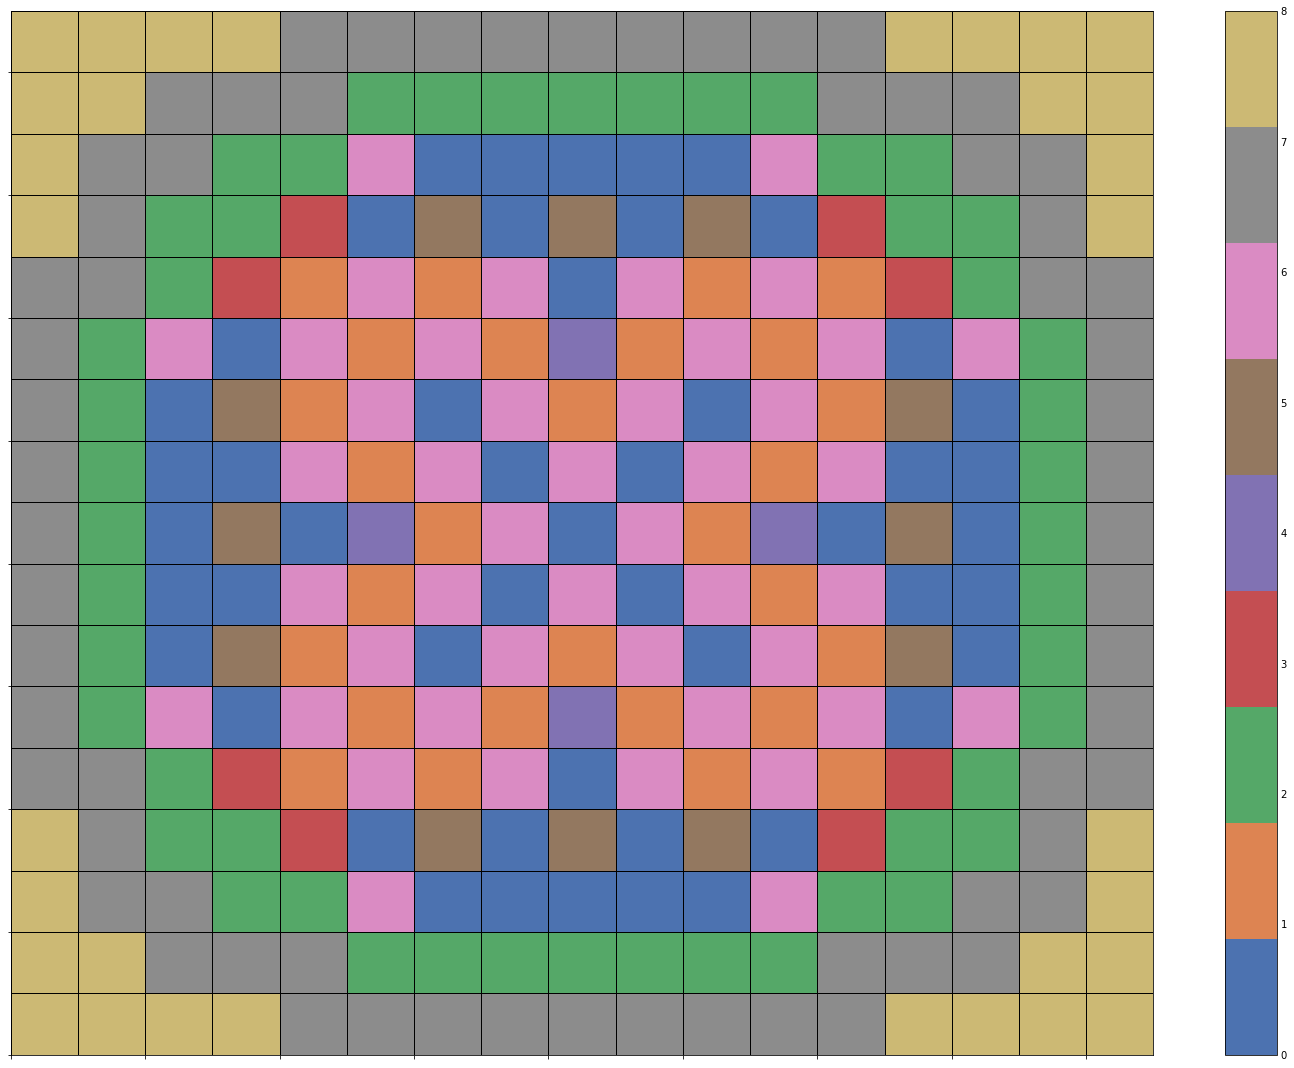

time: 2.32 s (started: 2022-11-24 08:43:03 +01:00)


In [3]:
x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

# geometry_half = geometry[:, int(len(y_mesh)/2):, int(len(x_mesh)/2):]
# x_mesh_half = x_mesh[:int(len(x_mesh)/2)]
# y_mesh_half = y_mesh[:int(len(y_mesh)/2)]

macrolib = mat.Macrolib(mat_lib, geometry)

from matplotlib.colors import ListedColormap
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-2., vmax=9)
# cmap = sns.color_palette("deep", as_cmap=True)
unique_mat, unique_inverse = np.unique(pblm, return_inverse=True)
fig, ax = plt.subplots(figsize=[6.4*4, 4.8*4])
cmap = ListedColormap(sns.color_palette("deep", as_cmap=True)[:len(unique_mat)])
quad = ax.pcolormesh(np.reshape(unique_inverse, pblm.shape), cmap=cmap, edgecolors="black")#, norm=norm)
# print(np.reshape(unique_inverse, pblm.shape)-0.5)
cbar = plt.colorbar(quad)
cbar.ax.tick_params(size=0)
# cbar.ax.set_yticklabels(unique_mat, labelsize=font_size)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Solver creation

In [5]:
s = solver.SolverFullSlepc(x_mesh, y_mesh,
                       macrolib, 0., 0., 0., 0.)
s_star = solver.SolverFullSlepc(s)
s_star.makeAdjoint()

time: 3.4 s (started: 2022-11-24 08:43:44 +01:00)


# Solve the problem

In [6]:
path_s = "./biblis_2d.h5"
path_s_star = "./biblis_2d_star.h5"
if os.path.exists(path_s):
    s.load(path_s)
    s_star.load(path_s_star)
else:
    s.solve(tol=1e-15, nb_eigen_values=800, inner_max_iter=100, tol_inner=1e-4)
    s_star.solve(tol=1e-15, nb_eigen_values=800, inner_max_iter=100, tol_inner=1e-4)
    s.dump(path_s)
    s_star.dump(path_s_star)

nb_ev = 150
s.removeEigenVectors(list(range(nb_ev, 801)))
s_star.removeEigenVectors(list(range(nb_ev, 801)))

egval = s.getEigenValues()

time: 3.59 s (started: 2022-11-24 08:43:52 +01:00)


# Visualisation of the direct flux 

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/grid_post_process.py:1183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


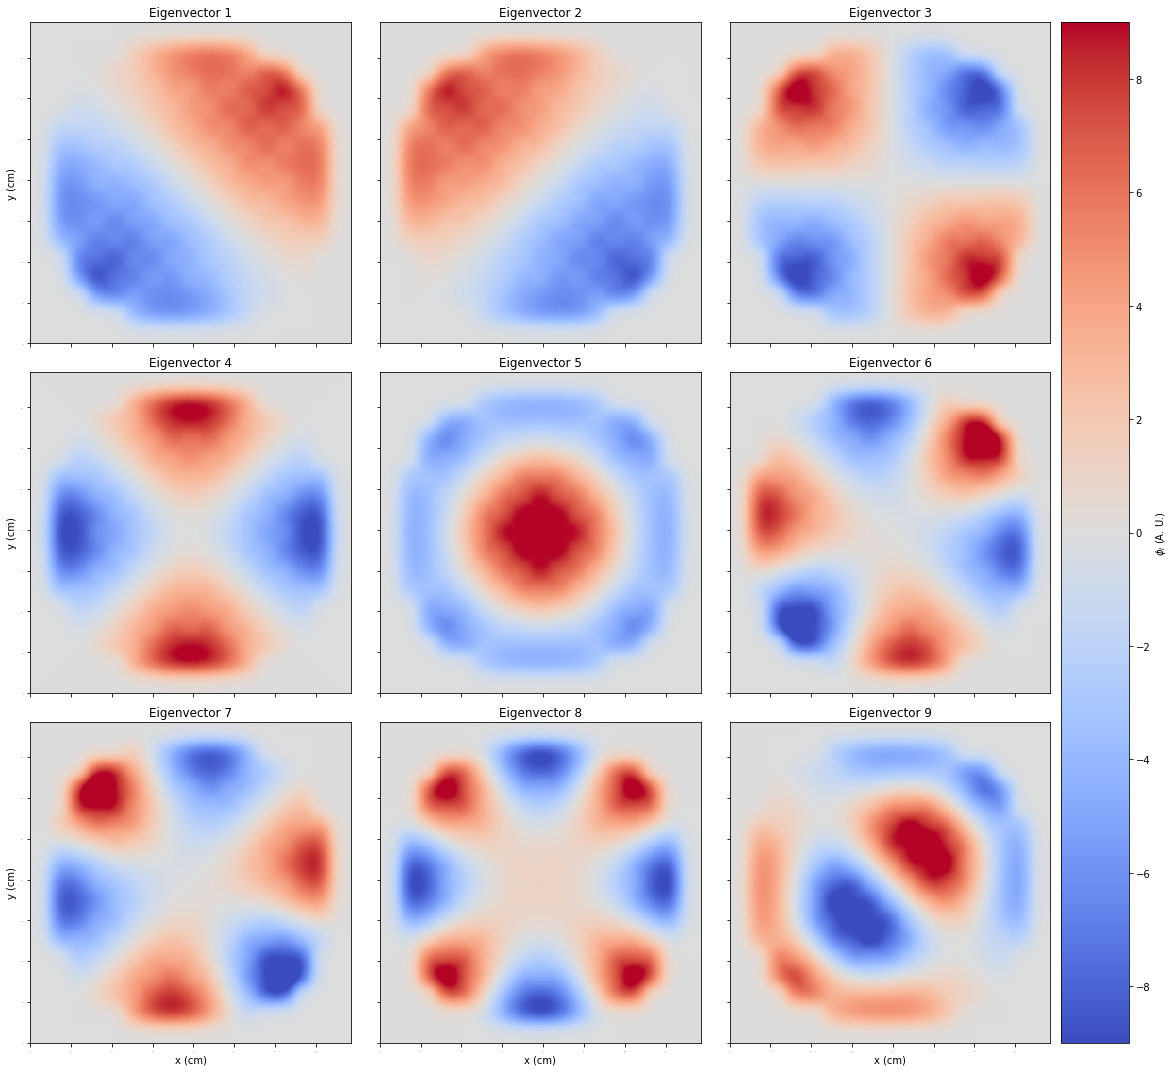

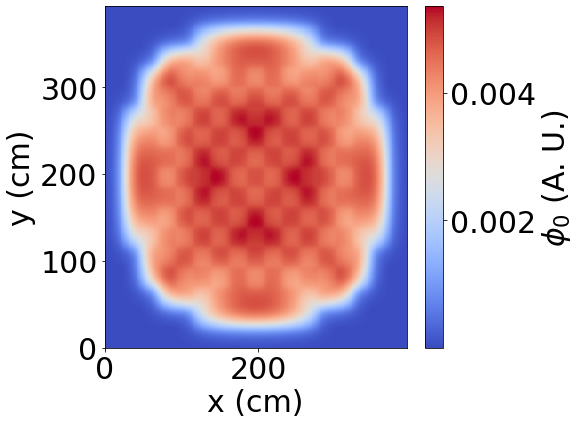

time: 3.4 s (started: 2022-11-24 08:49:38 +01:00)


In [8]:
# fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))

fig = plt.figure(figsize=(20, 15))

axs = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
for i in range(9):
    k = i % 3
    j = i // 3
    phi = s.getEigenVector(i+1) * 1000
    pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
                  show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
                  vmin=-9, vmax=+9)
    if j == 2:
        axs[i].set_xlabel("x (cm)")
    if k == 0:
        axs[i].set_ylabel("y (cm)")
    axs[i].set_title(f"Eigenvector {i+1}")

cb = axs[0].cax.colorbar(axs[0].collections[0])
axs[0].cax.toggle_label(True)
cb.set_label(r"$\phi_i$ (A. U.)")

# fig.tight_layout()

pp.plot_map2d(s.getEigenVector(0)[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh],
              show_stat_data=False, show_edge=False, label=r"$\phi_0$ (A. U.)", show_xy=True)

# Visualisation of the adjoint flux 

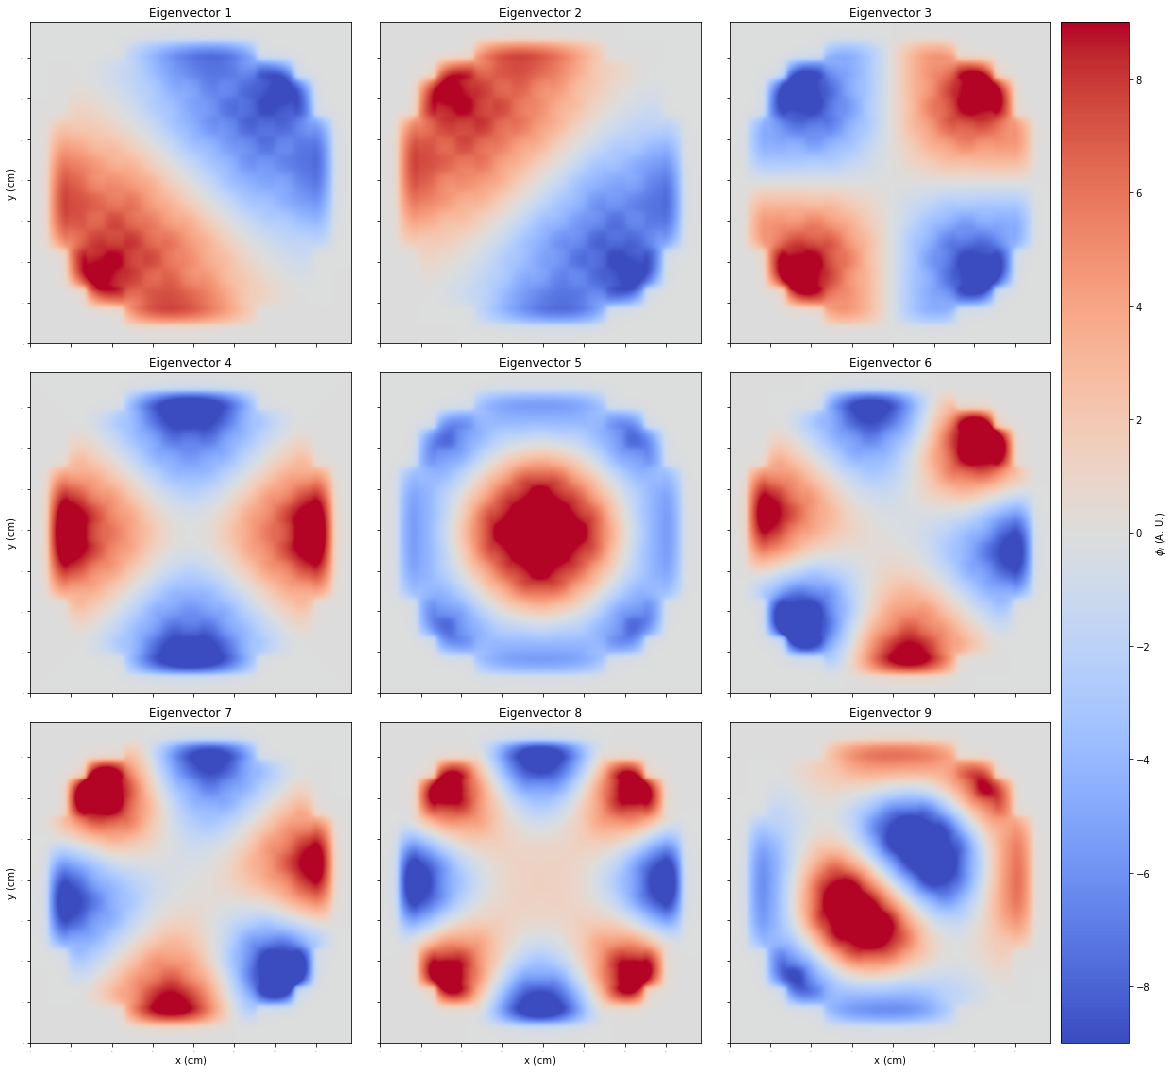

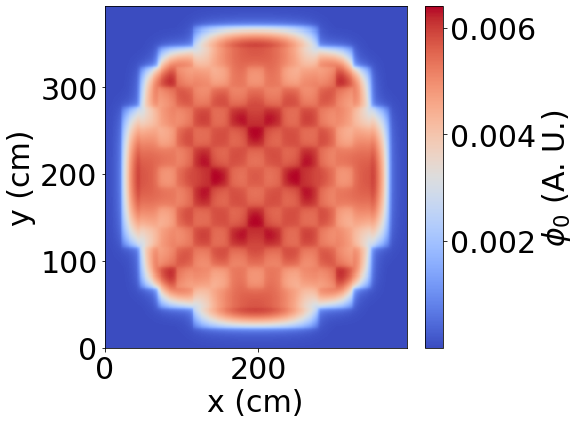

time: 2.94 s (started: 2022-11-24 08:49:47 +01:00)


In [9]:
# fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))

fig = plt.figure(figsize=(20, 15))

axs = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
for i in range(9):
    k = i % 3
    j = i // 3
    phi = s_star.getEigenVector(i+1) * 1000
    pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
                  show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
                  vmin=-9, vmax=+9)
    if j == 2:
        axs[i].set_xlabel("x (cm)")
    if k == 0:
        axs[i].set_ylabel("y (cm)")
    axs[i].set_title(f"Eigenvector {i+1}")

cb = axs[0].cax.colorbar(axs[0].collections[0])
axs[0].cax.toggle_label(True)
cb.set_label(r"$\phi_i$ (A. U.)")

# fig.tight_layout()

pp.plot_map2d(s_star.getEigenVector(0)[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh],
              show_stat_data=False, show_edge=False, label=r"$\phi_0$ (A. U.)", show_xy=True)

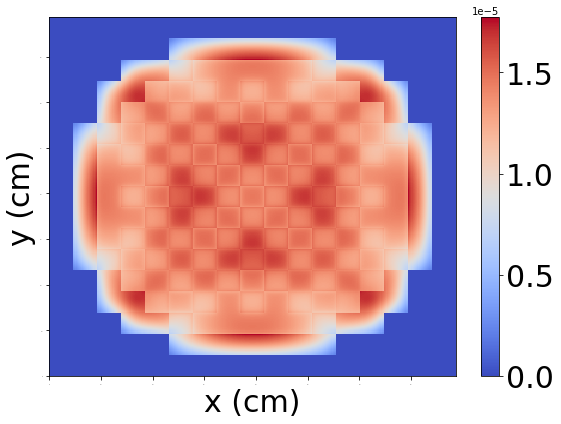

time: 1.09 s (started: 2022-11-24 08:49:54 +01:00)


In [10]:
power = s.normPower()
pp.plot_map2d(power.sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

# Check biorthogonality and degenerated ev

In [11]:
print(nb_ev)
set_log_level(log_level.info)

print("norm")
s.normPhiStarMPhi(s_star)
print("degenerated")
pert.handleDegeneratedEigenvalues(s, s_star, 1e-6)
print("birothogonality")
pert.checkBiOrthogonality(s, s_star, 1e-6, False, True)

print(len(s.getEigenValues()))
print(len(s_star.getEigenValues()))



150
[2022-11-24 08:50:07.698] [info] New orthogonalisation with a group of 2 eigenvectors from 1 to 2
113
113
time: 13min 24s (started: 2022-11-24 08:50:01 +01:00)
[2022-11-24 08:50:07.712] [info] New orthogonalisation with a group of 2 eigenvectors from 6 to 7
[2022-11-24 08:50:07.730] [info] New orthogonalisation with a group of 2 eigenvectors from 9 to 10
[2022-11-24 08:50:07.750] [info] New orthogonalisation with a group of 2 eigenvectors from 12 to 13
[2022-11-24 08:50:07.768] [info] New orthogonalisation with a group of 2 eigenvectors from 18 to 19
[2022-11-24 08:50:07.787] [info] New orthogonalisation with a group of 2 eigenvectors from 21 to 22
[2022-11-24 08:50:07.805] [info] New orthogonalisation with a group of 2 eigenvectors from 23 to 24
[2022-11-24 08:50:07.824] [info] New orthogonalisation with a group of 2 eigenvectors from 32 to 33
[2022-11-24 08:50:07.842] [info] New orthogonalisation with a group of 2 eigenvectors from 34 to 35
[2022-11-24 08:50:07.861] [info] New or

# First order modal expansion reconstruction  


## Removal op pertubation

In [12]:
mat_lib_pert = mat.Materials(mat_lib)
sigr = mat_lib_pert.getValue("fuel1", 1, "SIGR")*1.01
mat_lib_pert.setValue("fuel1", 1, "SIGR", sigr)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_removal = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_removal.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_removal = solver.SolverFullSlepc(s_pert_removal)

[2022-11-24 09:03:47.922] [info] Number of converged eigenpairs: 1
[2022-11-24 09:03:47.932] [info] Eigen value 0 = 1.02257 +- 1.20e-06
time: 12.1 s (started: 2022-11-24 09:03:35 +01:00)


In [13]:
set_log_level(log_level.debug)
_, _, a_removal = pert.firstOrderPerturbation(
    s, s_star, s_recons_removal, "PhiStarMPhi")

time: 22.8 s (started: 2022-11-24 09:03:59 +01:00)


a0 =  0.9986396370626175


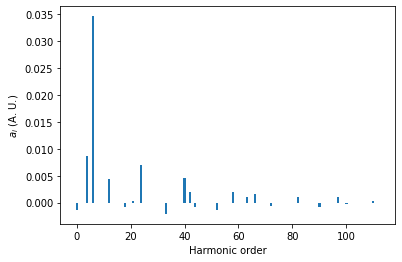

time: 294 ms (started: 2022-11-24 09:04:26 +01:00)


In [14]:
def plot_recons_coeff(a):
    print("a0 = ", a[0])
    a[0] -= 1
    fig, ax = plt.subplots()
    y_pos = np.arange(len(a))
    ax.bar(y_pos, a)
    ax.set_xlabel("Harmonic order")
    ax.set_ylabel("$a_i$ (A. U.)")
    plt.show()
    
plot_recons_coeff(a_removal)

vp recons =  1.0224872264269342
vp pert =  1.022574869291803
vp ref =  1.0252767233369111
sens -257.7066773144996
sens recons -266.08898423820915
delta recons -8.382306923709558


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.746924840907428 3.930228134026772 -7.227693107930963 6.5695741660133065 0.0006642790547909341 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.0433878396964235 0.1862411438675545 -0.7093832359345085 0.6877803539299832 2.161210241934033e-06 0.0032534673889638476
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.007942305432851786 3.6471256588864653 -7.193584604394304 6.559214164753341 0.0006667046748477148 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.014950036077564842 0.1991550960114897 -0.6806980227830043 0.6611031121951039 2.016653309522068e-06 0.0030248075131357097


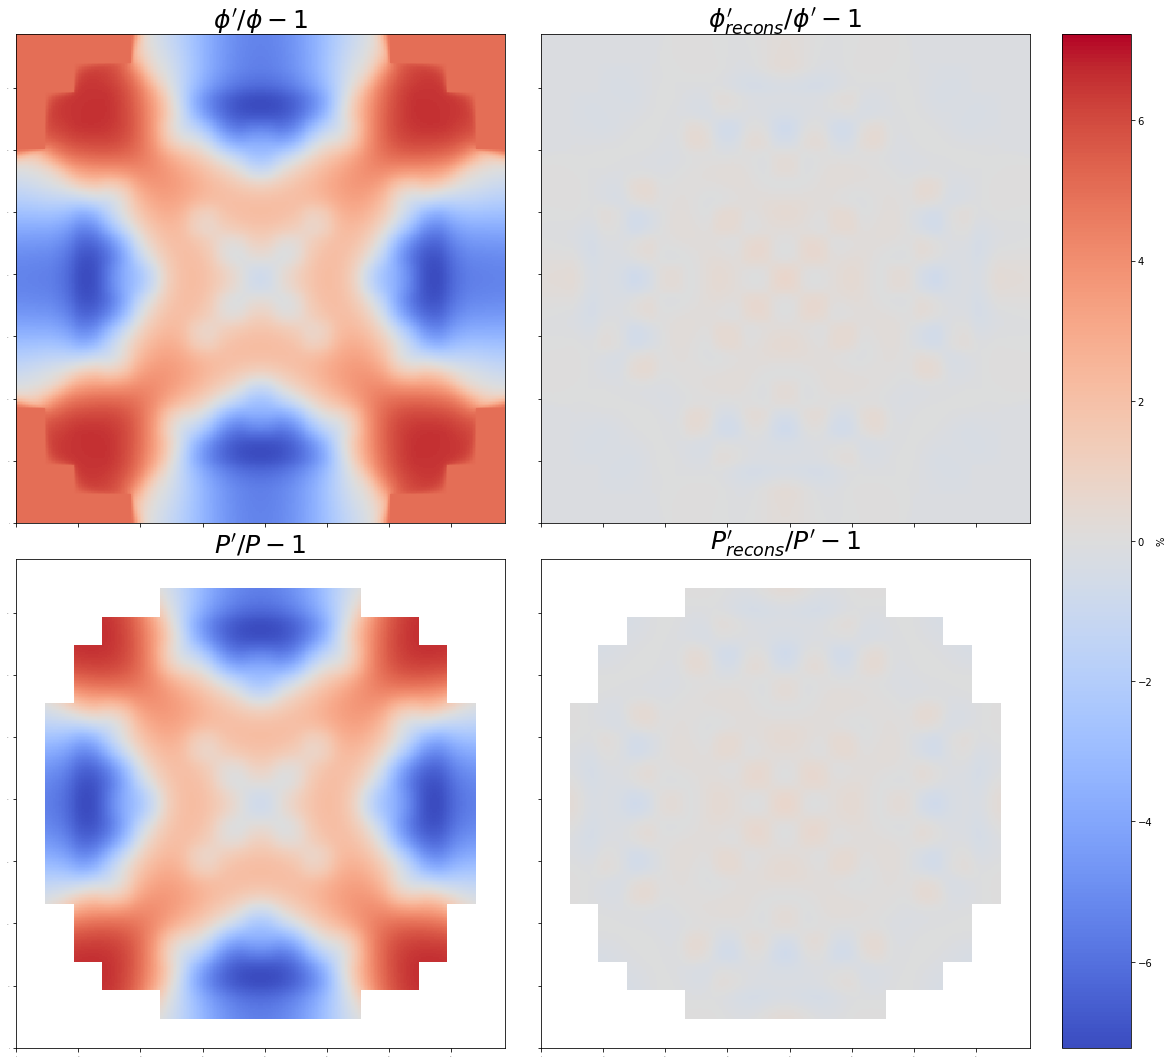

time: 1.95 s (started: 2022-11-24 09:04:50 +01:00)


In [15]:
def plot_delta(s, s_recons, s_pert):
    egval_recons = s_recons.getEigenValues()
    egval_pert = s_pert.getEigenValues()
    egval = s.getEigenValues()
    print("vp recons = ", egval_recons[0])
    print("vp pert = ", egval_pert[0])
    print("vp ref = ", egval[0])

    print("sens", 1e5*(egval_pert[0]-egval[0])/(egval[0]*egval_pert[0]))
    print("sens recons", 1e5*(egval_recons[0]-egval[0])/(egval[0]*egval_recons[0]))
    print("delta recons", 1e5*(egval_recons[0]-egval_pert[0])/(egval_pert[0]*egval_recons[0]))

    power_pert = s_pert.normPower().sum(axis=0)
    power = s.normPower().sum(axis=0)
    power_recons = s_recons.normPower().sum(axis=0)

    ev0 = s.getEigenVector(0).sum(axis=0)
    ev0_recons = s_recons.getEigenVector(0).sum(axis=0)
    ev0_pert = s_pert.getEigenVector(0).sum(axis=0)
    delta = 100*(ev0_pert-ev0)/ev0
    delta_recons = 100*(ev0_recons-ev0_pert)/ev0_pert

    ev0_pert_normed = ev0_pert / np.nansum(ev0_pert)
    ev0_recons_normed = ev0_recons / np.nansum(ev0_recons)
    ev0_normed = ev0 / np.nansum(ev0)

    ev0_pert_re = np.nansum(ev0_normed*np.log(ev0_normed/ev0_pert_normed))
    ev0_recons_re = np.nansum(ev0_pert_normed*np.log(ev0_pert_normed/ev0_recons_normed))

    delta_power = 100*(power_pert-power)/power
    delta_recons_power = 100*(power_recons-power_pert)/power_pert

    power_normed = power[~np.isnan(power)] / np.nansum(power)
    power_pert_normed = power_pert[~np.isnan(power_pert)] / np.nansum(power_pert)
    power_recons_normed = power_recons[~np.isnan(power_recons)] / np.nansum(power_recons)
    power_pert_re = np.nansum(power_normed*np.log(power_normed/power_pert_normed))
    power_recons_re = np.nansum(power_pert_normed*np.log(power_pert_normed/power_recons_normed))

    print("pert/ref - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta), np.std(delta),
     np.min(delta), np.max(delta), ev0_pert_re, 1)
    print("recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta_recons), np.std(delta_recons),
     np.min(delta_recons), np.max(delta_recons), ev0_recons_re, ev0_recons_re/ev0_pert_re)


    print("power pert/ref - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_power), np.nanstd(delta_power),
     np.nanmin(delta_power), np.nanmax(delta_power), power_pert_re, 1)
    print("power recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_recons_power), np.nanstd(delta_recons_power),
     np.nanmin(delta_recons_power), np.nanmax(delta_recons_power), power_recons_re, power_recons_re/power_pert_re)

    # sns.histplot([delta.flatten(), delta_recons.flatten()], log_scale=(False, True))
    # plt.show()
    # sns.histplot([delta.flatten(), delta_recons.flatten()])
    # plt.show()

    # sns.histplot([delta_power.flatten(), delta_recons_power.flatten()])
    # plt.show()


    # for i in range(9):
    #     k = i % 3
    #     j = i // 3
    #     phi = s.getEigenVector(i+1) * 1000
    #     pp.plot_map2d(phi[:, 0, :, :].sum(axis=0), [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False,
    #                 show_stat_data=False, show_edge=False, show_xy=False, fig=fig, ax=axs[i],
    #                 vmin=-9, vmax=+9)
    #     if j == 2:
    #         axs[i].set_xlabel("x (cm)")
    #     if k == 0:
    #         axs[i].set_ylabel("y (cm)")
    #     axs[i].set_title(f"Eigenvector {i+1}")

    # cb = axs[0].cax.colorbar(axs[0].collections[0])
    # axs[0].cax.toggle_label(True)
    # cb.set_label(r"$\phi_i$ (A. U.)")


    fig = plt.figure(figsize=(20, 15))

    axs = ImageGrid(fig, 111,
                    nrows_ncols=(2, 2),
                    axes_pad=0.5,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.45)

    max_delta = np.max(np.abs(delta))
    pp.plot_map2d(delta.sum(axis=0),
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$\phi'/\phi - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[0])

    pp.plot_map2d(delta_recons.sum(axis=0),
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$\phi_{recons}'/\phi' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[1])
    # pp.plot_map2d(100*(ev0_recons[:, :, 0]-ev0_pert[:, :, 0])/ev0_pert[:, :, 0], [x_mesh, y_mesh],
    #             show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
    #             title="$\phi_0^{recons}'/\phi_0' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")
    # pp.plot_map2d(100*(ev0_recons[:, :, 1]-ev0_pert[:, :, 1])/ev0_pert[:, :, 1], [x_mesh, y_mesh],
    #             show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
    #             title="$\phi_1^{recons}'/\phi_1' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")


    max_delta = np.nanmax(np.abs(delta_power))
    pp.plot_map2d(delta_power,
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$P'/P - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[2])

    pp.plot_map2d(delta_recons_power,
                [x_mesh, y_mesh], show=False, x_label=None, y_label=None, cbar=False, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                title="$P_{recons}'/P' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en", fig=fig, ax=axs[3])

    cb = axs[0].cax.colorbar(axs[0].collections[0])
    axs[0].cax.toggle_label(True)
    cb.set_label(r"%")

    # axs[2].set_xlabel("x (cm)")
    # axs[3].set_xlabel("x (cm)")
    # axs[0].set_ylabel("y (cm)")
    # axs[2].set_ylabel("y (cm)")
        
    return (delta, delta_recons, ev0_recons_re/ev0_pert_re,
            delta_power, delta_recons_power, power_recons_re/power_pert_re)


(delta_sigr, delta_recons_sigr, re_sigr,
            delta_power_sigr, delta_recons_power_sigr, re_power_sigr) = plot_delta(s, s_recons_removal, s_pert_removal)

[2022-11-24 09:05:15.398] [debug] Solver : krylovschur
[2022-11-24 09:05:15.398] [debug] Inner solver : 
[2022-11-24 09:05:15.398] [debug] Inner precond : 
[2022-11-24 09:05:15.398] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:05:15.398] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:05:15.398] [debug] Max. outer iteration : 500
[2022-11-24 09:05:15.398] [debug] Max. inner iteration : 10
[2022-11-24 09:05:21.826] [info] Number of converged eigenpairs: 1
[2022-11-24 09:05:21.826] [debug] Number of outter iteration: 8
[2022-11-24 09:05:21.826] [debug] Slepc converged reason: tolerance
[2022-11-24 09:05:21.847] [info] Eigen value 0 = 1.02315 +- 1.20e-06
a0 =  0.9989281975316618


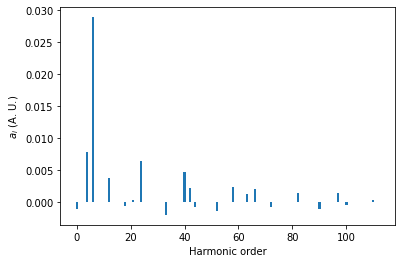

vp recons =  1.0230789350913068
vp pert =  1.0231473599501248
vp ref =  1.0252767233369111
sens -202.98806170632645
sens recons -209.52488250430386
delta recons -6.536820797977433


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.7250243563853905 3.151363500077165 -5.791250583044289 5.316628322397289 0.00043400782277093903 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.11955666865150155 0.27157653614908767 -1.0764255173649675 0.6477153155960574 4.451079717757785e-06 0.010255759191941983
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.006427232795722841 3.0650251169514355 -6.321972775396022 5.30858127273552 0.0004744070805776299 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.01012082928515585 0.2884691349019212 -1.0161004619739504 0.8835537340052648 4.1296451929427755e-06 0.008704855728364321


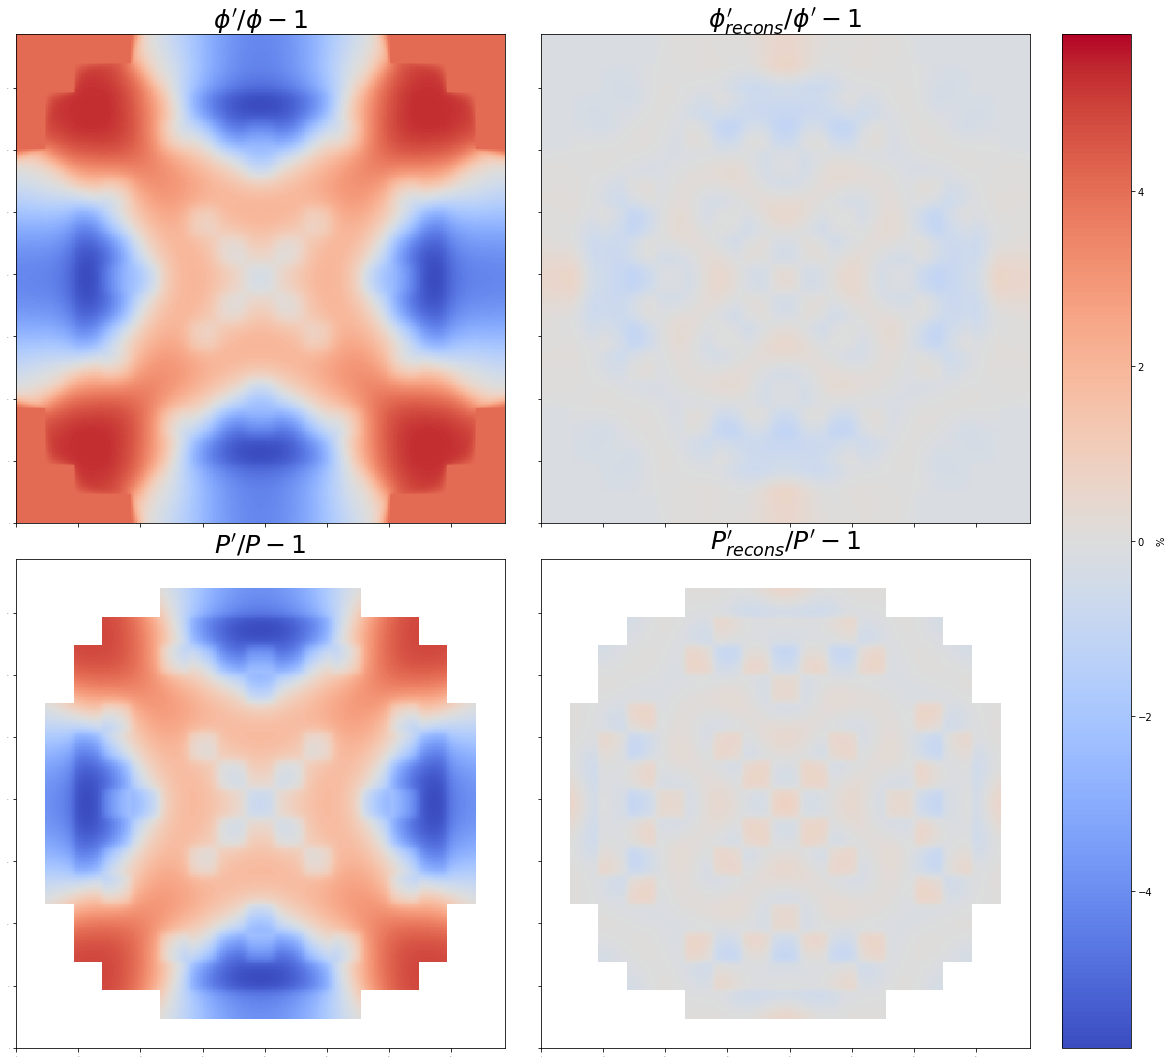

time: 43 s (started: 2022-11-24 09:05:10 +01:00)


In [16]:
mat_lib_pert = mat.Materials(mat_lib)
sigr = mat_lib_pert.getValue("fuel1", 2, "SIGR")*1.01
mat_lib_pert.setValue("fuel1", 2, "SIGR", sigr)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_removal2 = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_removal2.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_removal2 = solver.SolverFullSlepc(s_pert_removal2)

set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_removal2, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_removal2, delta_recons_removal2, re_removal2,
            delta_power_removal2, delta_recons_power_removal2, re_power_removal2) = plot_delta(s, s_recons_removal2, s_pert_removal2)

## Fuel xs perturbation 

In [17]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("fuel1", 2, "NU_SIGF")*1.01
mat_lib_pert.setValue("fuel1", 2, "NU_SIGF", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_fiss = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_fiss.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fiss = solver.SolverFullSlepc(s_pert_fiss)

[2022-11-24 09:06:04.422] [debug] Solver : krylovschur
[2022-11-24 09:06:04.423] [debug] Inner solver : 
[2022-11-24 09:06:04.423] [debug] Inner precond : 
[2022-11-24 09:06:04.423] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:06:04.423] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:06:04.423] [debug] Max. outer iteration : 500
[2022-11-24 09:06:04.423] [debug] Max. inner iteration : 10
[2022-11-24 09:06:10.995] [info] Number of converged eigenpairs: 1
[2022-11-24 09:06:10.995] [debug] Number of outter iteration: 8
[2022-11-24 09:06:10.995] [debug] Slepc converged reason: tolerance
[2022-11-24 09:06:11.007] [info] Eigen value 0 = 1.02754 +- 1.20e-06
time: 11.6 s (started: 2022-11-24 09:05:59 +01:00)


a0 =  1.0


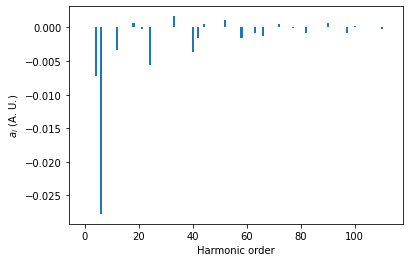

vp recons =  1.0274873383071232
vp pert =  1.0275400695267762
vp ref =  1.0252767233369111
sens 214.83801065838915
sens recons 209.8435042893333
delta recons -4.994506369055839


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.7351745706356603 3.1718914894134578 -5.212506393852231 5.973021364600995 0.0004497314301272135 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.020794965448836703 0.13159384818145334 -0.40128353686095347 0.4387846389532324 1.1180514089844459e-06 0.0024860424112857485
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.01697818115115279 3.187505013626465 -5.204844738675853 6.783235891633207 0.0005062435422304443 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.0034164287391206067 0.13959686155228046 -0.38650316603581664 0.42401854386663723 1.0016160753357993e-06 0.001978526127805615


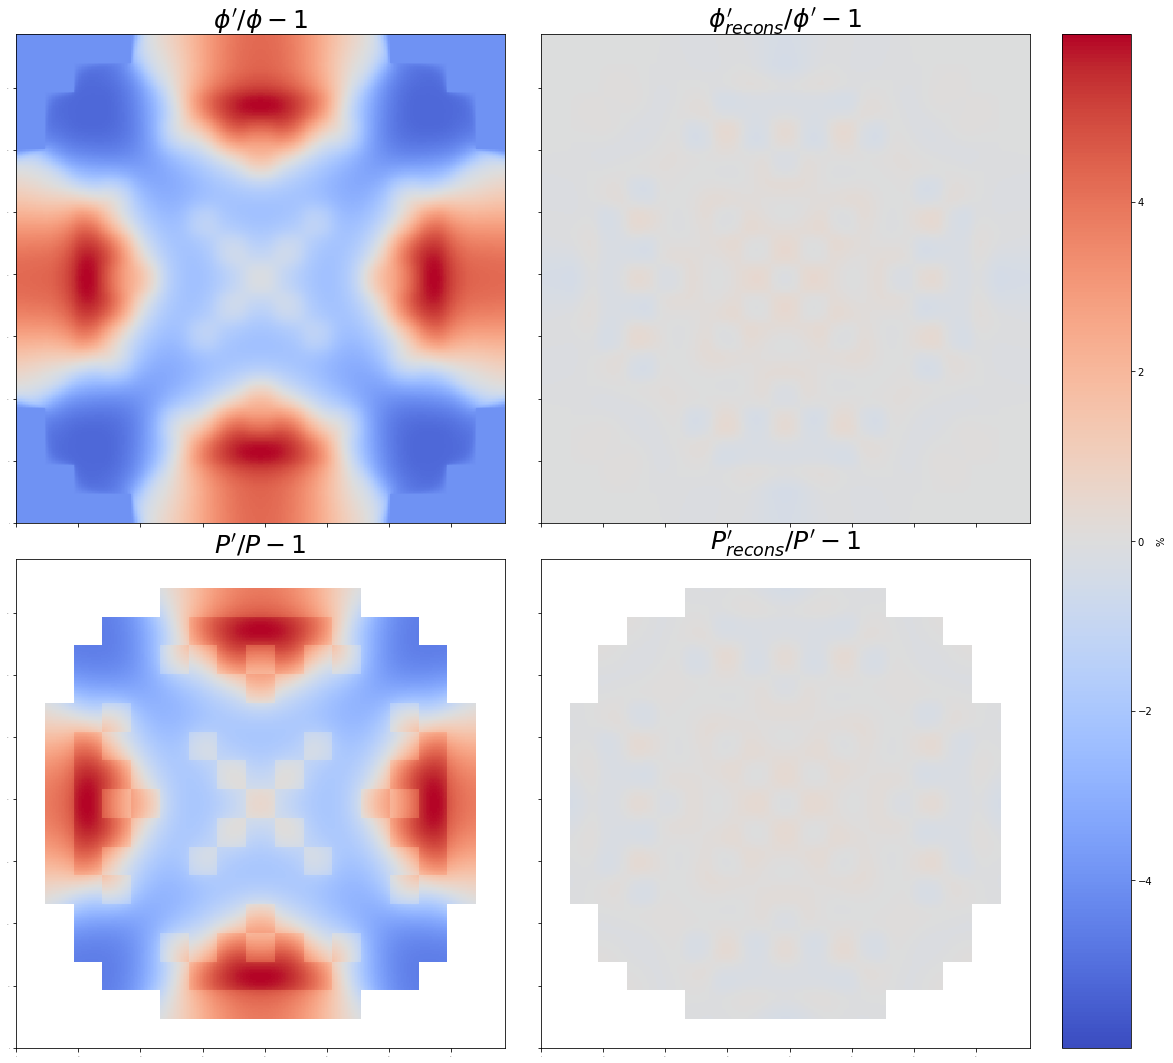

time: 31.7 s (started: 2022-11-24 09:06:11 +01:00)


In [18]:
set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fiss, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_sigf, delta_recons_sigf, re_sigf,
            delta_power_sigf, delta_recons_power_sigf, re_power_sigf) = plot_delta(s, s_recons_fiss, s_pert_fiss)

## Diff fuel1 pertubation

[2022-11-24 09:06:55.177] [debug] Solver : krylovschur
[2022-11-24 09:06:55.177] [debug] Inner solver : 
[2022-11-24 09:06:55.177] [debug] Inner precond : 
[2022-11-24 09:06:55.177] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:06:55.177] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:06:55.177] [debug] Max. outer iteration : 500
[2022-11-24 09:06:55.177] [debug] Max. inner iteration : 10
[2022-11-24 09:07:01.767] [info] Number of converged eigenpairs: 1
[2022-11-24 09:07:01.767] [debug] Number of outter iteration: 8
[2022-11-24 09:07:01.767] [debug] Slepc converged reason: tolerance
[2022-11-24 09:07:01.808] [info] Eigen value 0 = 1.02527 +- 1.19e-06
a0 =  0.9999979173792007


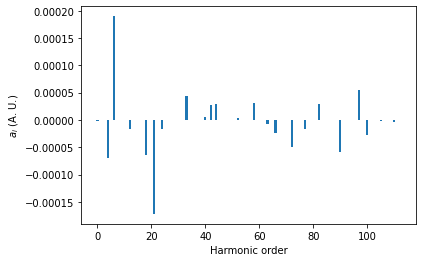

vp recons =  1.025272452811653
vp pert =  1.025272478141303
vp ref =  1.0252767233369111
sens -0.4038474164681866
sens recons -0.4062570477873194
delta recons -0.0024096313191327885


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.012498681861018542 0.03374688372998591 -0.07518485934930073 0.09324450792925006 4.7902128822802487e-08 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.00172946581754585 0.007538479818042821 -0.028298480052485257 0.02306854255623244 2.4534170673761868e-09 0.05121728674004787
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.003615171523198137 0.03340541424330079 -0.08176947486410789 0.10486391646322363 5.026678210355641e-08 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.00012983784926091848 0.009520605433757653 -0.039799349628765475 0.02493053412522825 4.438902994917693e-09 0.08830688596244234


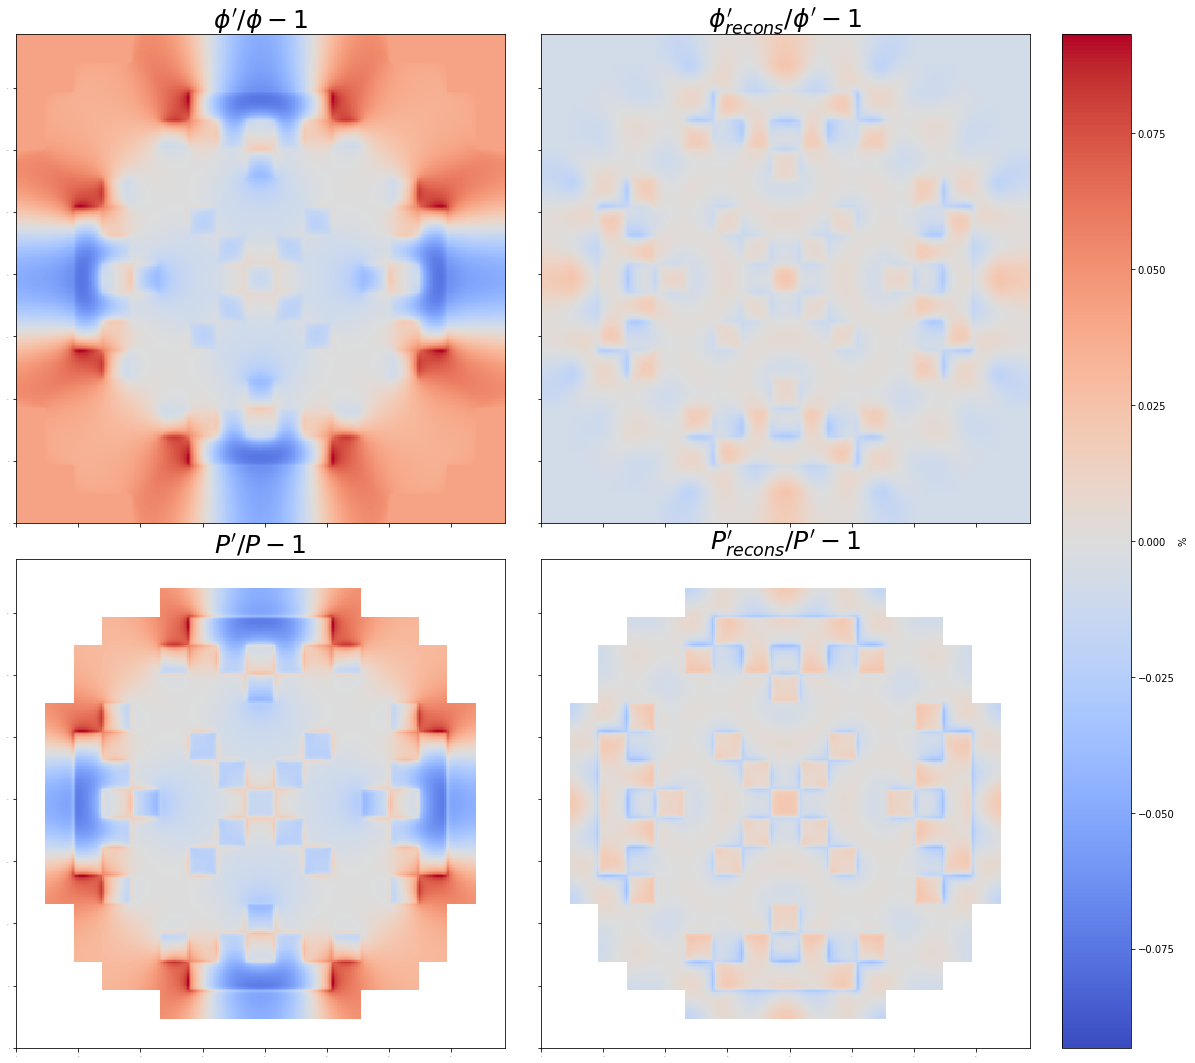

time: 45.4 s (started: 2022-11-24 09:06:50 +01:00)


In [19]:
mat_lib_pert = mat.Materials(mat_lib)
D = mat_lib_pert.getValue("fuel1", 2, "D")*1.01
mat_lib_pert.setValue("fuel1", 2, "D", D)
D = mat_lib_pert.getValue("fuel1", 1, "D")*1.01
mat_lib_pert.setValue("fuel1", 1, "D", D)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_D = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_D.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_D = solver.SolverFullSlepc(s_pert_D)

set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_D, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_D, delta_recons_D, re_D,
            delta_power_D, delta_recons_power_D, re_power_D) = plot_delta(s, s_recons_D, s_pert_D)

## Scattering fuel1 pertubation

[2022-11-24 09:07:54.874] [debug] Solver : krylovschur
[2022-11-24 09:07:54.874] [debug] Inner solver : 
[2022-11-24 09:07:54.874] [debug] Inner precond : 
[2022-11-24 09:07:54.874] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:07:54.874] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:07:54.874] [debug] Max. outer iteration : 500
[2022-11-24 09:07:54.874] [debug] Max. inner iteration : 10
[2022-11-24 09:08:01.061] [info] Number of converged eigenpairs: 1
[2022-11-24 09:08:01.061] [debug] Number of outter iteration: 8
[2022-11-24 09:08:01.061] [debug] Slepc converged reason: tolerance
[2022-11-24 09:08:01.068] [info] Eigen value 0 = 1.02572 +- 1.21e-06
a0 =  1.000214288262927


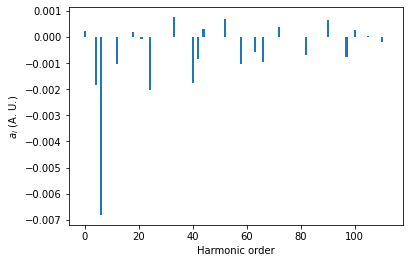

vp recons =  1.0257161328730378
vp pert =  1.0257173339331844
vp ref =  1.0252767233369111
sens 41.8973104355991
sens recons 41.78315150932593
delta recons -0.11415892627318036


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.2737515000628954 0.6658126822275117 -1.203841917267331 1.1777141981489914 2.0314688150498277e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.09952604818708306 0.19854773921154803 -0.44862870948573425 0.6129783743201285 2.084742247736598e-06 0.10262240957341319
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.0016452925221257953 0.7880288191376787 -1.2022855843081783 1.7781796985179021 3.159739694361233e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0011005641160823513 0.18778120015709168 -0.4520287555923776 0.5684041630383788 1.75194371210025e-06 0.055445824072999146


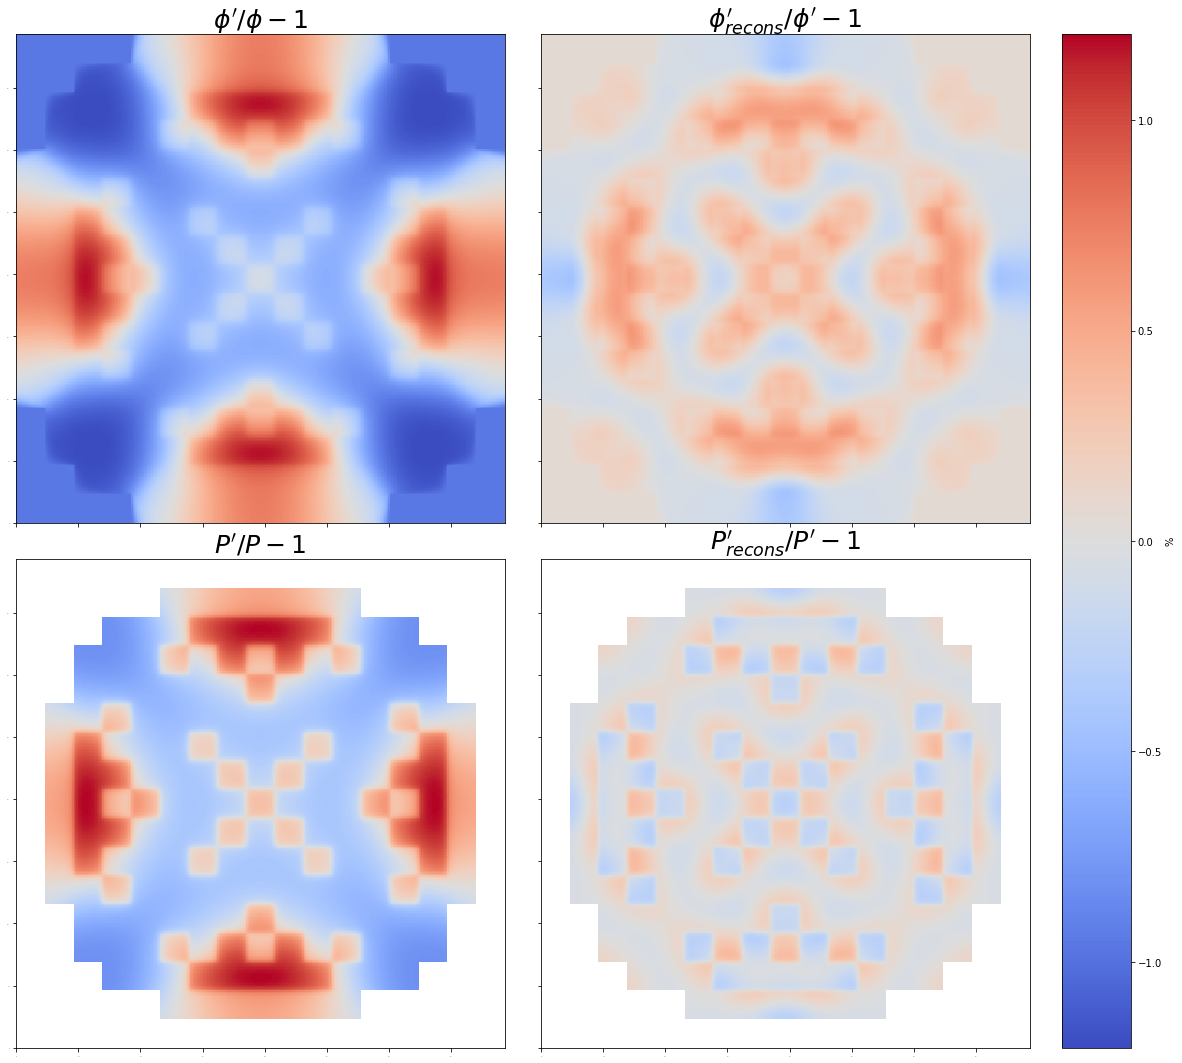

time: 43.9 s (started: 2022-11-24 09:07:49 +01:00)


In [20]:
mat_lib_pert = mat.Materials(mat_lib)
scat = mat_lib_pert.getValue("fuel1", 1, "2")*1.01
mat_lib_pert.setValue("fuel1", 1, "2", scat)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_scatt = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_scatt.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_scatt = solver.SolverFullSlepc(s_pert_scatt)

set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_scatt, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_scatt, delta_recons_scatt, re_scatt,
            delta_power_scatt, delta_recons_power_scatt, re_power_scatt) = plot_delta(s, s_recons_scatt, s_pert_scatt)

## Refl xs perturbation 

In [21]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "SIGA")*1.01
mat_lib_pert.setValue("refl", 1, "SIGA", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_refl = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_refl.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl = solver.SolverFullSlepc(s_pert_refl)

[2022-11-24 09:08:49.938] [debug] Solver : krylovschur
[2022-11-24 09:08:49.938] [debug] Inner solver : 
[2022-11-24 09:08:49.938] [debug] Inner precond : 
[2022-11-24 09:08:49.938] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:08:49.938] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:08:49.938] [debug] Max. outer iteration : 500
[2022-11-24 09:08:49.938] [debug] Max. inner iteration : 10
[2022-11-24 09:08:56.153] [info] Number of converged eigenpairs: 1
[2022-11-24 09:08:56.154] [debug] Number of outter iteration: 8
[2022-11-24 09:08:56.154] [debug] Slepc converged reason: tolerance
[2022-11-24 09:08:56.160] [info] Eigen value 0 = 1.02527 +- 1.18e-06
time: 11.2 s (started: 2022-11-24 09:08:44 +01:00)


a0 =  0.9999973481903416


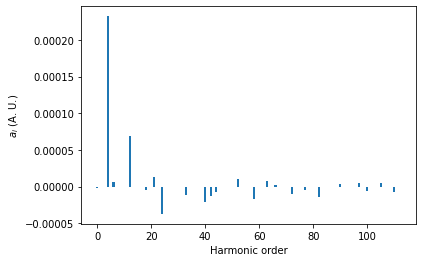

vp recons =  1.0252712856594761
vp pert =  1.0252712910162936
vp ref =  1.0252767233369111
sens -0.5167797645814339
sens recons -0.5172893643877486
delta recons -0.0005095998063146909


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.06418625762384443 0.0929049766941266 -0.2689312453887559 0.03953294008387696 5.4456659660515236e-08 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.04327474823418296 0.06710485294584774 -0.007395020558725617 0.20877067627733326 8.441877673274059e-09 0.15502011555429632
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.004406430602877251 0.028963555924812506 -0.10672017260767518 0.03950566239741009 3.524587330106342e-08 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.00042542474216374006 0.003930951276400545 -0.006911438731019091 0.04403907611624907 3.8968690506284824e-10 0.011056242009787024


(array([[[-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         [-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         [-0.22760992, -0.22760992, -0.22760992, ..., -0.2276292 ,
          -0.2276292 , -0.2276292 ],
         ...,
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377],
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377],
         [-0.22756183, -0.22756183, -0.22756183, ..., -0.22767377,
          -0.22767377, -0.22767377]]]),
 array([[[0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         [0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         [0.17034453, 0.17034453, 0.17034453, ..., 0.17036394,
          0.17036394, 0.17036394],
         ...,
         [0.1702963 , 0.1702963 , 0.1702963 , ..., 

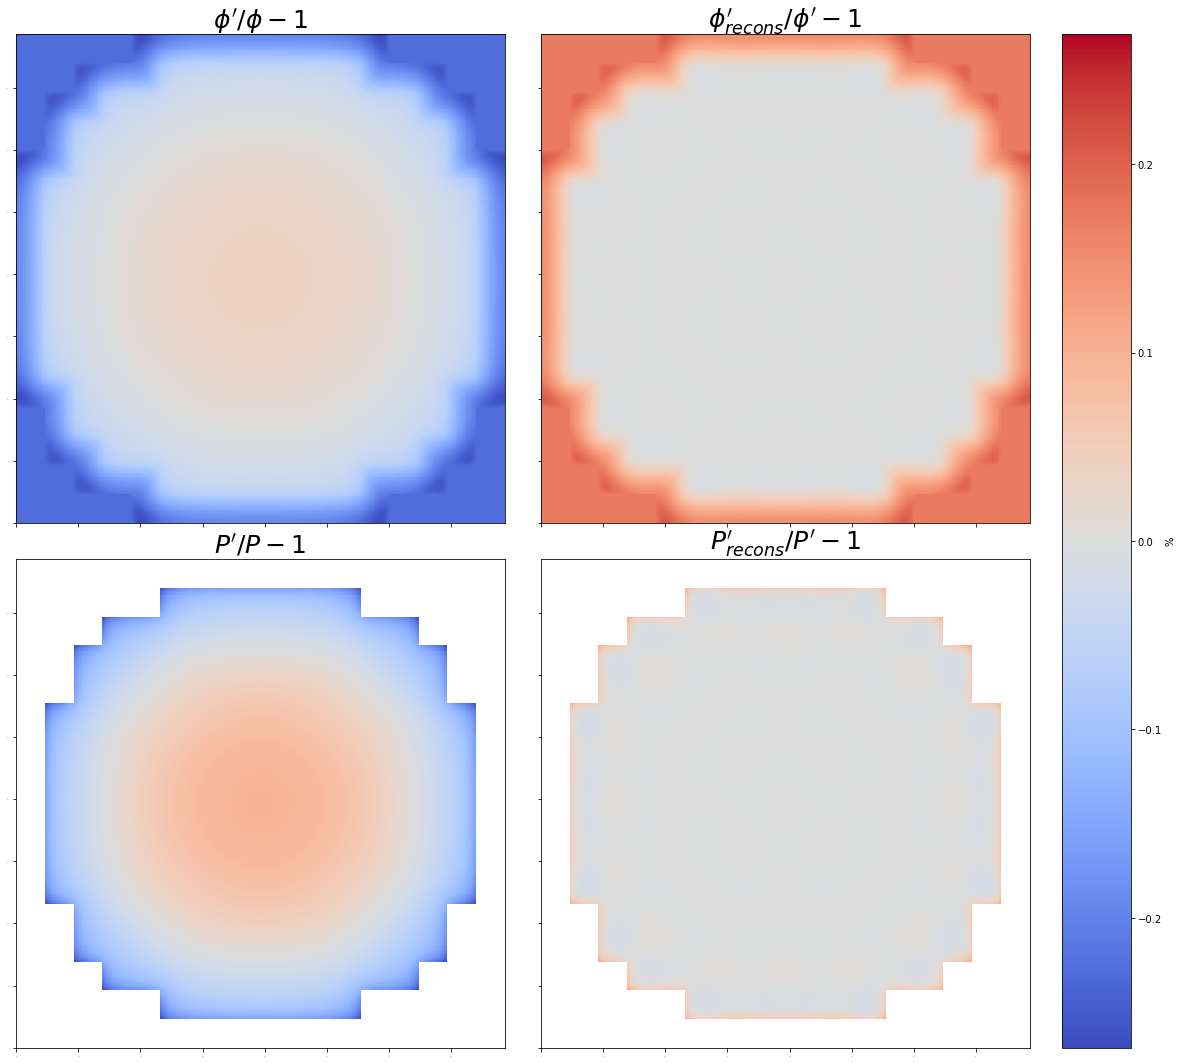

time: 34.2 s (started: 2022-11-24 09:09:05 +01:00)


In [22]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl, "PhiStarMPhi")

plot_recons_coeff(a)
plot_delta(s, s_recons_refl, s_pert_refl)

In [23]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "2")*1.01
mat_lib_pert.setValue("refl", 1, "2", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_refl2 = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_refl2.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl2 = solver.SolverFullSlepc(s_pert_refl2)

[2022-11-24 09:09:50.682] [debug] Solver : krylovschur
[2022-11-24 09:09:50.682] [debug] Inner solver : 
[2022-11-24 09:09:50.682] [debug] Inner precond : 
[2022-11-24 09:09:50.682] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:09:50.682] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:09:50.682] [debug] Max. outer iteration : 500
[2022-11-24 09:09:50.682] [debug] Max. inner iteration : 10
[2022-11-24 09:09:56.804] [info] Number of converged eigenpairs: 1
[2022-11-24 09:09:56.804] [debug] Number of outter iteration: 8
[2022-11-24 09:09:56.805] [debug] Slepc converged reason: tolerance
[2022-11-24 09:09:56.818] [info] Eigen value 0 = 1.02525 +- 1.19e-06
time: 11.1 s (started: 2022-11-24 09:09:45 +01:00)


a0 =  0.9999861683365859


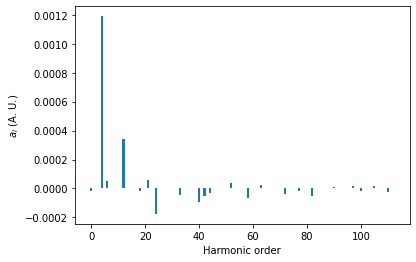

vp recons =  1.0252483607718241
vp pert =  1.0252485606149448
vp ref =  1.0252767233369111
sens -2.679195232008307
sens recons -2.6982073697090976
delta recons -0.019012137700790518


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.40495188032064 0.6109483532439572 -1.892960226874634 0.2014618730652216 1.4852828151114175e-06 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.3113387924059783 0.5061023218923919 -0.015973478116436648 1.6481709907324353 3.0096511859555527e-07 0.20263152278711216
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.019164827355812777 0.13746653889131966 -0.3692051899689503 0.2013202261087215 8.543841124903929e-07 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  -5.434696344104261e-05 0.015465010780350636 -0.152054887194774 0.08137099353219131 6.378156790789552e-09 0.007465209965337775


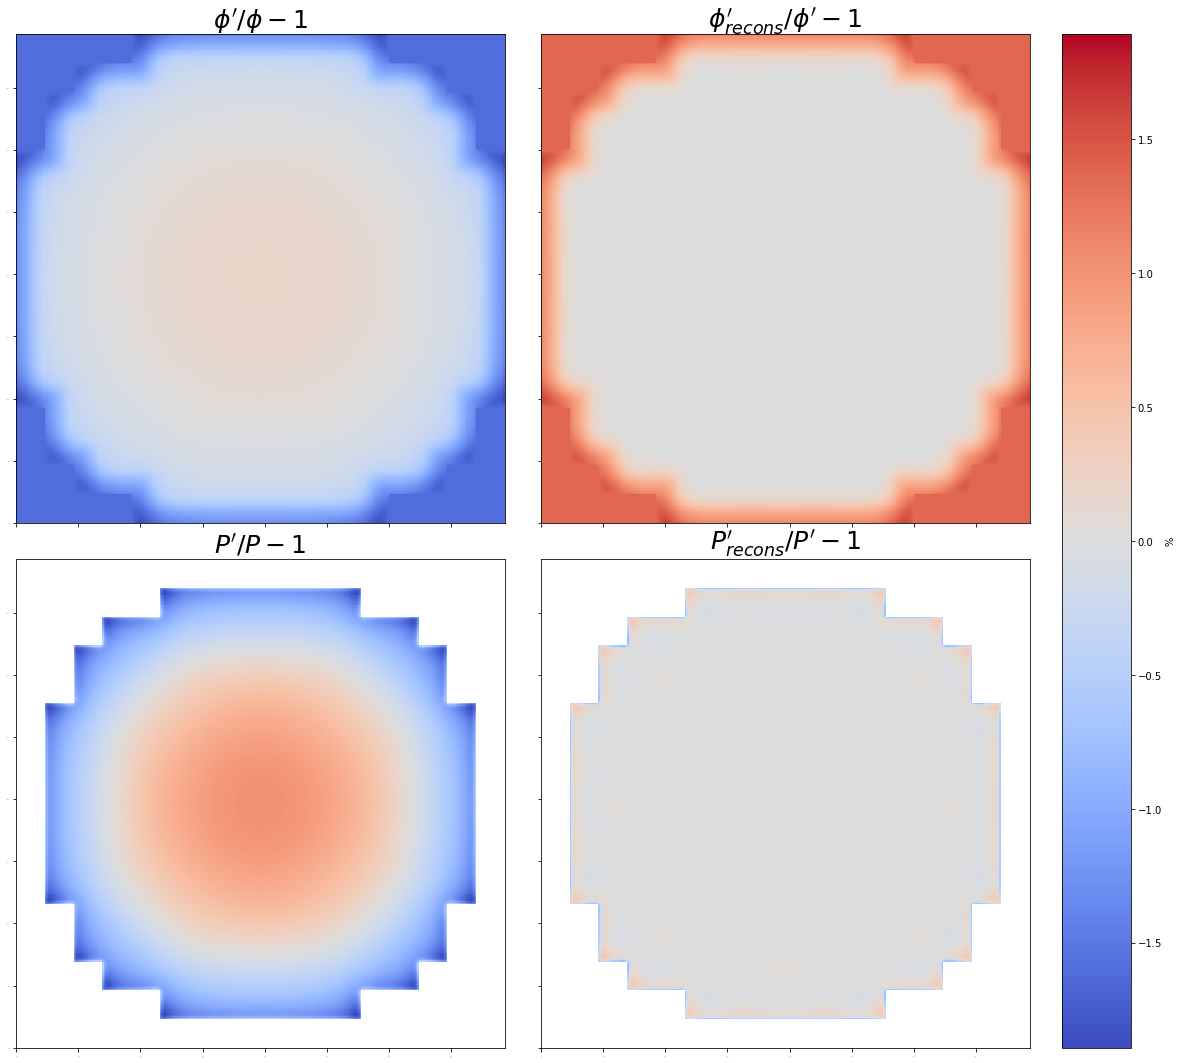

time: 34.4 s (started: 2022-11-24 09:09:58 +01:00)


In [24]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl2, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_refl, delta_recons_refl, re_refl,
            delta_power_refl, delta_recons_power_refl, re_power_refl) = plot_delta(s, s_recons_refl2, s_pert_refl2)

[2022-11-24 09:10:48.336] [debug] Solver : krylovschur
[2022-11-24 09:10:48.336] [debug] Inner solver : 
[2022-11-24 09:10:48.336] [debug] Inner precond : 
[2022-11-24 09:10:48.336] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:10:48.336] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:10:48.336] [debug] Max. outer iteration : 500
[2022-11-24 09:10:48.336] [debug] Max. inner iteration : 10
[2022-11-24 09:10:54.525] [info] Number of converged eigenpairs: 1
[2022-11-24 09:10:54.525] [debug] Number of outter iteration: 8
[2022-11-24 09:10:54.525] [debug] Slepc converged reason: tolerance
[2022-11-24 09:10:54.531] [info] Eigen value 0 = 1.02523 +- 1.19e-06
a0 =  0.9999771371279254


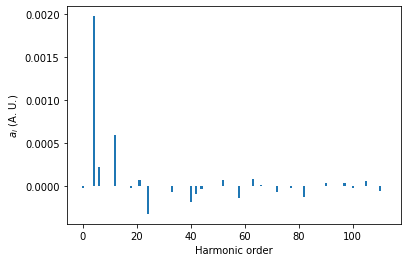

vp recons =  1.0252298417957777
vp pert =  1.0252302215865332
vp ref =  1.0252767233369111
sens -4.423915295673517
sens recons -4.460048106782445
delta recons -0.03613281110892809
pert/ref - 1 (mean, std, min, max, relative entropy) :  0.20338300218160113 0.5819143443345252 -0.7006579767885316 1.965912746855523 2.631744317332596e-06 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  -0.3679575788496689 0.6766774962177986 -2.3770833221421848 0.21263672791664384 3.479995223378366e-07 0.13223150898281466
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.03525868384977217 0.24002064603511228 -0.6660375707797885 0.3366213720468548 2.5042667640776535e-06 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0027348593835503877 0.027029431687996073 -0.04881637516027314 0.18222334736239024 2.127798958115333e-08 0.008496694476153472


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


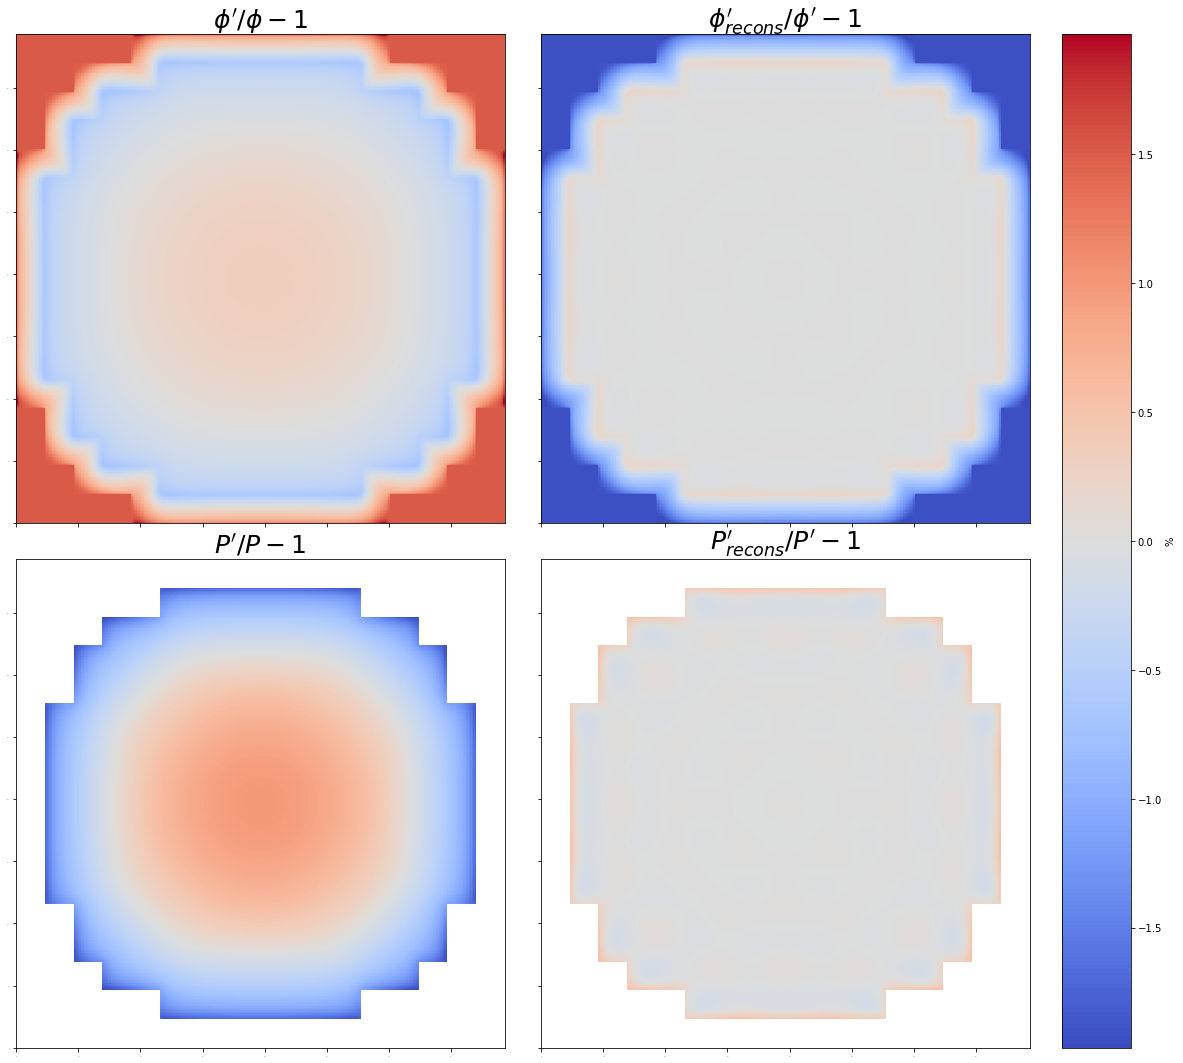

time: 43.4 s (started: 2022-11-24 09:10:43 +01:00)


In [25]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "D")*1.01
mat_lib_pert.setValue("refl", 1, "D", sigf)
sigf = mat_lib_pert.getValue("refl", 2, "D")*1.01
mat_lib_pert.setValue("refl", 2, "D", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, geometry)
s_pert_refl3 = solver.SolverFullSlepc(x_mesh, y_mesh,
                            macrolib_pert, 0., 0., 0., 0.)
s_pert_refl3.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl3 = solver.SolverFullSlepc(s_pert_refl3)

set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl3, "PhiStarMPhi")

plot_recons_coeff(a)
(delta_refl_D, delta_recons_refl_D, re_refl_D,
            delta_power_refl_D, delta_recons_power_refl_D, re_power_refl_D) = plot_delta(s, s_recons_refl3, s_pert_refl3)


## Modification of only one fuel assembly 

In [26]:
fuel1 = [[1.4360, 0.0095042, 0.0058708, 1, 0., 0.017754, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3635, 0.0750058, 0.0960670*1.01, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel1, "fuel1_pert", reac_names)

x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1_pert", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

macrolib_pert = mat.Macrolib(mat_lib, geometry)

s_pert_fuel = solver.SolverFullSlepc(x_mesh, y_mesh,
                                macrolib_pert, 0., 0., 0., 0.)
s_pert_fuel.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel = solver.SolverFullSlepc(s_pert_fuel)

[2022-11-24 09:11:45.348] [debug] Solver : krylovschur
[2022-11-24 09:11:45.348] [debug] Inner solver : 
[2022-11-24 09:11:45.348] [debug] Inner precond : 
[2022-11-24 09:11:45.348] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:11:45.348] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:11:45.348] [debug] Max. outer iteration : 500
[2022-11-24 09:11:45.348] [debug] Max. inner iteration : 10
[2022-11-24 09:11:52.336] [info] Number of converged eigenpairs: 1
[2022-11-24 09:11:52.336] [debug] Number of outter iteration: 10
[2022-11-24 09:11:52.336] [debug] Slepc converged reason: tolerance
[2022-11-24 09:11:52.345] [info] Eigen value 0 = 1.02533 +- 1.19e-06
time: 13.6 s (started: 2022-11-24 09:11:38 +01:00)


vp recons =  1.0253293552555023
vp pert =  1.02533067085491
vp ref =  1.0252767233369111
sens 5.131761002669832
sens recons 5.006620951232907
delta recons -0.12514005143692503
pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.1260584530602266 0.5118754751018721 -0.7781073520480317 2.8775283178999524 1.6017681252192858e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0043252945170288324 0.39989147762718835 -1.4756942568540896 1.193833658358793 9.22181774638775e-06 0.5757273853308363
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.03273080536403221 0.5743398152956977 -0.7778906671232387 3.6527080357029327 1.7292594200846394e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0026839340389707856 0.4203426212362817 -1.4480308281405598 1.1817647170184757 9.202380979684572e-06 0.5321573427793822


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


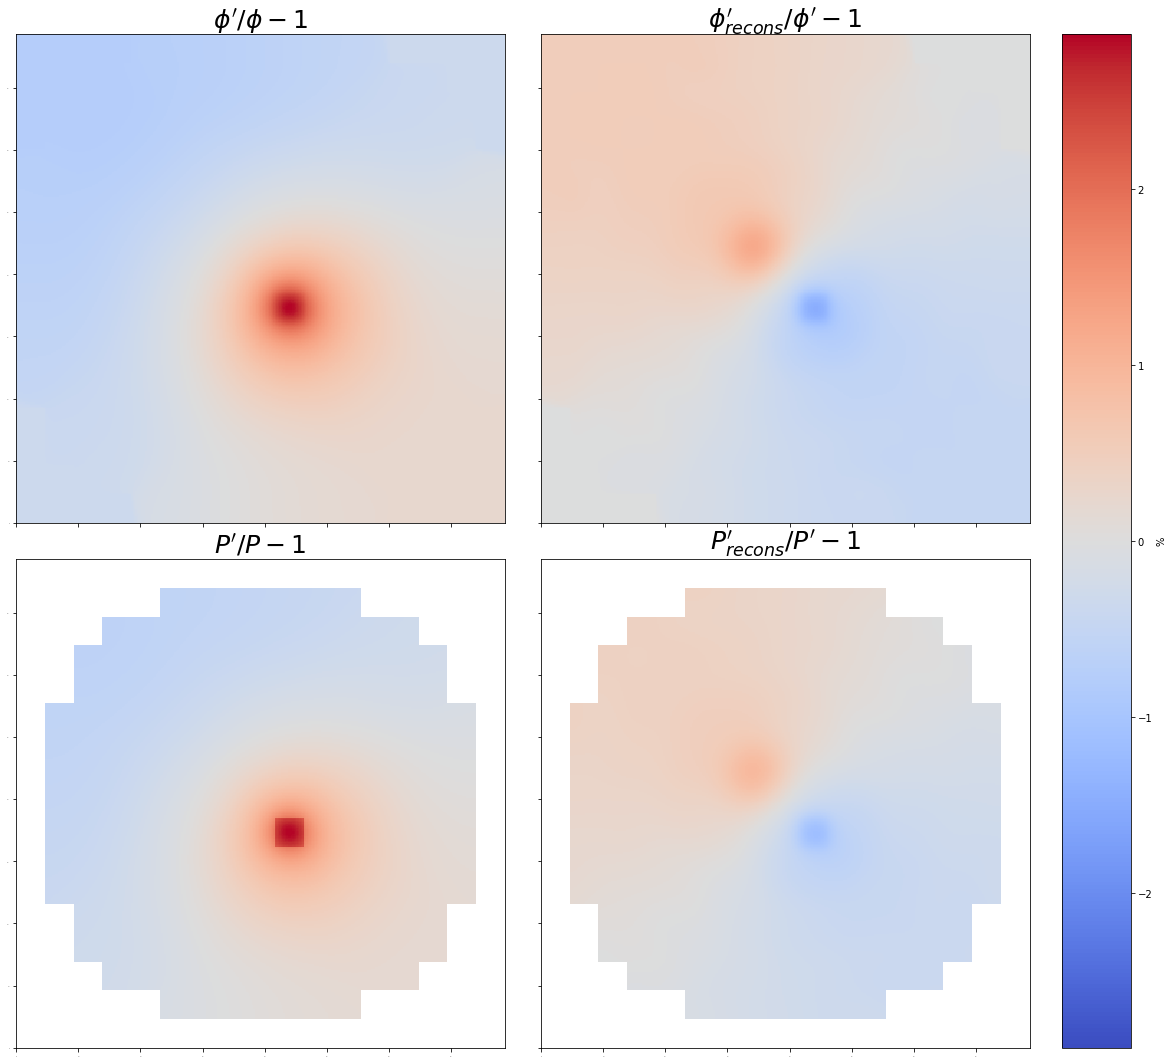

time: 31.8 s (started: 2022-11-24 09:11:52 +01:00)


In [27]:
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel, "PhiStarMPhi")

(delta_sigf_ass, delta_recons_sigf_ass, re_sigf_ass,
            delta_power_sigf_ass, delta_recons_power_sigf_ass, re_power_sigf_ass) = plot_delta(s, s_recons_fuel, s_pert_fuel)

In [28]:
# _, _, _ = pert.highOrderPerturbation(2, 
#     s, s_star, s_recons_fuel)

# plot_delta(s, s_recons_fuel, s_pert_fuel)

time: 730 µs (started: 2022-11-24 09:12:35 +01:00)


## One ass sigr

[2022-11-24 09:12:52.215] [debug] Solver : krylovschur
[2022-11-24 09:12:52.215] [debug] Inner solver : 
[2022-11-24 09:12:52.215] [debug] Inner precond : 
[2022-11-24 09:12:52.215] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:12:52.215] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:12:52.215] [debug] Max. outer iteration : 500
[2022-11-24 09:12:52.215] [debug] Max. inner iteration : 10
[2022-11-24 09:12:58.869] [info] Number of converged eigenpairs: 1
[2022-11-24 09:12:58.869] [debug] Number of outter iteration: 10
[2022-11-24 09:12:58.869] [debug] Slepc converged reason: tolerance
[2022-11-24 09:12:58.876] [info] Eigen value 0 = 1.02523 +- 1.21e-06
vp recons =  1.0252246417557844
vp pert =  1.0252262558422045
vp ref =  1.0252767233369111
sens -4.801212504350484
sens recons -4.954776013451942
delta recons -0.15356350910145738


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  0.11762524084451165 0.4855798896205901 -2.8164866930171875 0.7372918682208405 1.4541644349869808e-05 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0026043166999180816 0.3822604348863833 -1.4148872055813244 1.2825109210014687 8.428289026536802e-06 0.5795966964776071
power pert/ref - 1 (mean, std, min, max, relative entropy) :  0.030714394901764926 0.5386884229013903 -3.351731108995013 0.7370860683543344 1.5389163027445653e-05 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.002308591433243097 0.41193422641633703 -1.3973983123946294 1.859500954493045 8.823297237826461e-06 0.5733448415674482


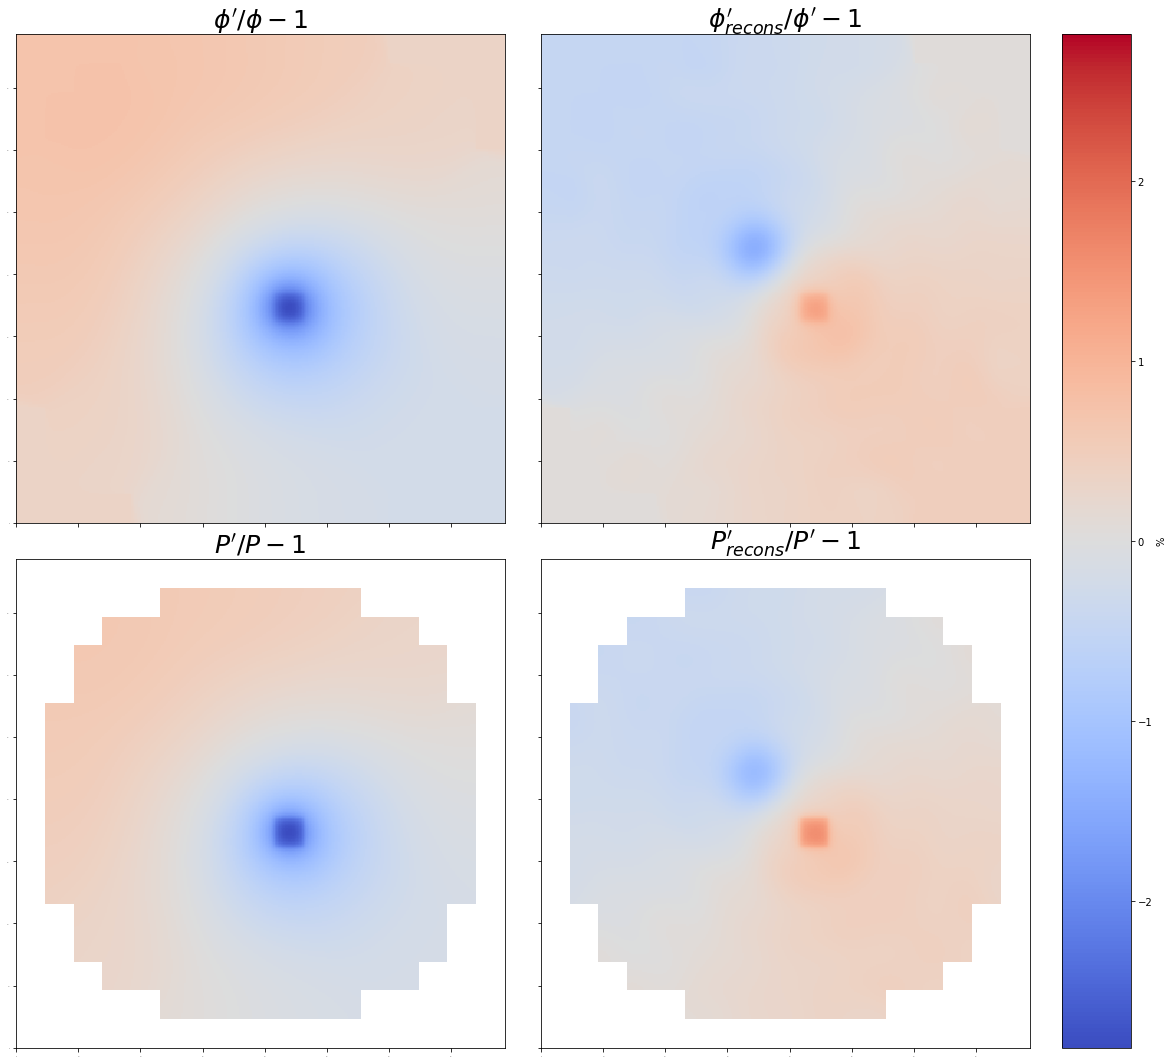

time: 43.1 s (started: 2022-11-24 09:12:47 +01:00)


In [29]:
fuel1 = [[1.4360, 0.0095042, 0.0058708, 1, 0., 0.017754, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3635, 0.0750058*1.01, 0.0960670, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel1, "fuel1_pert_sigr", reac_names)

x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1_pert_sigr", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

macrolib_pert = mat.Macrolib(mat_lib, geometry)

s_pert_fuel_sigr = solver.SolverFullSlepc(x_mesh, y_mesh,
                                macrolib_pert, 0., 0., 0., 0.)
s_pert_fuel_sigr.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel_sigr = solver.SolverFullSlepc(s_pert_fuel_sigr)

_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel_sigr, "PhiStarMPhi")

(delta_sigr_ass, delta_recons_sigr_ass, re_sigr_ass,
            delta_power_sigr_ass, delta_recons_power_sigr_ass, re_power_sigr_ass) = plot_delta(s, s_recons_fuel_sigr, s_pert_fuel_sigr)

## One ass scatt

[2022-11-24 09:13:53.659] [debug] Solver : krylovschur
[2022-11-24 09:13:53.659] [debug] Inner solver : 
[2022-11-24 09:13:53.659] [debug] Inner precond : 
[2022-11-24 09:13:53.659] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-11-24 09:13:53.659] [debug] Tolerance in inner iteration : 1.00e-03
[2022-11-24 09:13:53.659] [debug] Max. outer iteration : 500
[2022-11-24 09:13:53.659] [debug] Max. inner iteration : 10
[2022-11-24 09:14:00.348] [info] Number of converged eigenpairs: 1
[2022-11-24 09:14:00.348] [debug] Number of outter iteration: 10
[2022-11-24 09:14:00.348] [debug] Slepc converged reason: tolerance
[2022-11-24 09:14:00.354] [info] Eigen value 0 = 1.02529 +- 1.20e-06
vp recons =  1.025287023264452
vp pert =  1.0252870675615486
vp ref =  1.0252767233369111
sens 0.9840368588050504
sens recons 0.9798229578626411
delta recons -0.004213900942409411


/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.027217672693902215 0.10091216146956068 -0.1534569215421399 0.6735105995392483 6.335855006566902e-07 1
recons/pert - 1 (mean, std, min, max, relative entropy) :  0.0025589955205931863 0.08168862680474279 -0.18446485942683344 0.4672822762125125 3.9133780394934815e-07 0.6176558705079892
power pert/ref - 1 (mean, std, min, max, relative entropy) :  -0.006674430218648325 0.13092902614748397 -0.15341511178229164 1.2673125290703529 9.172232905466427e-07 1
power recons/pert - 1 (mean, std, min, max, relative entropy) :  0.00029950072681402353 0.09885376575436652 -0.768661496820312 0.4593483568558804 5.22536413478873e-07 0.569693790884283


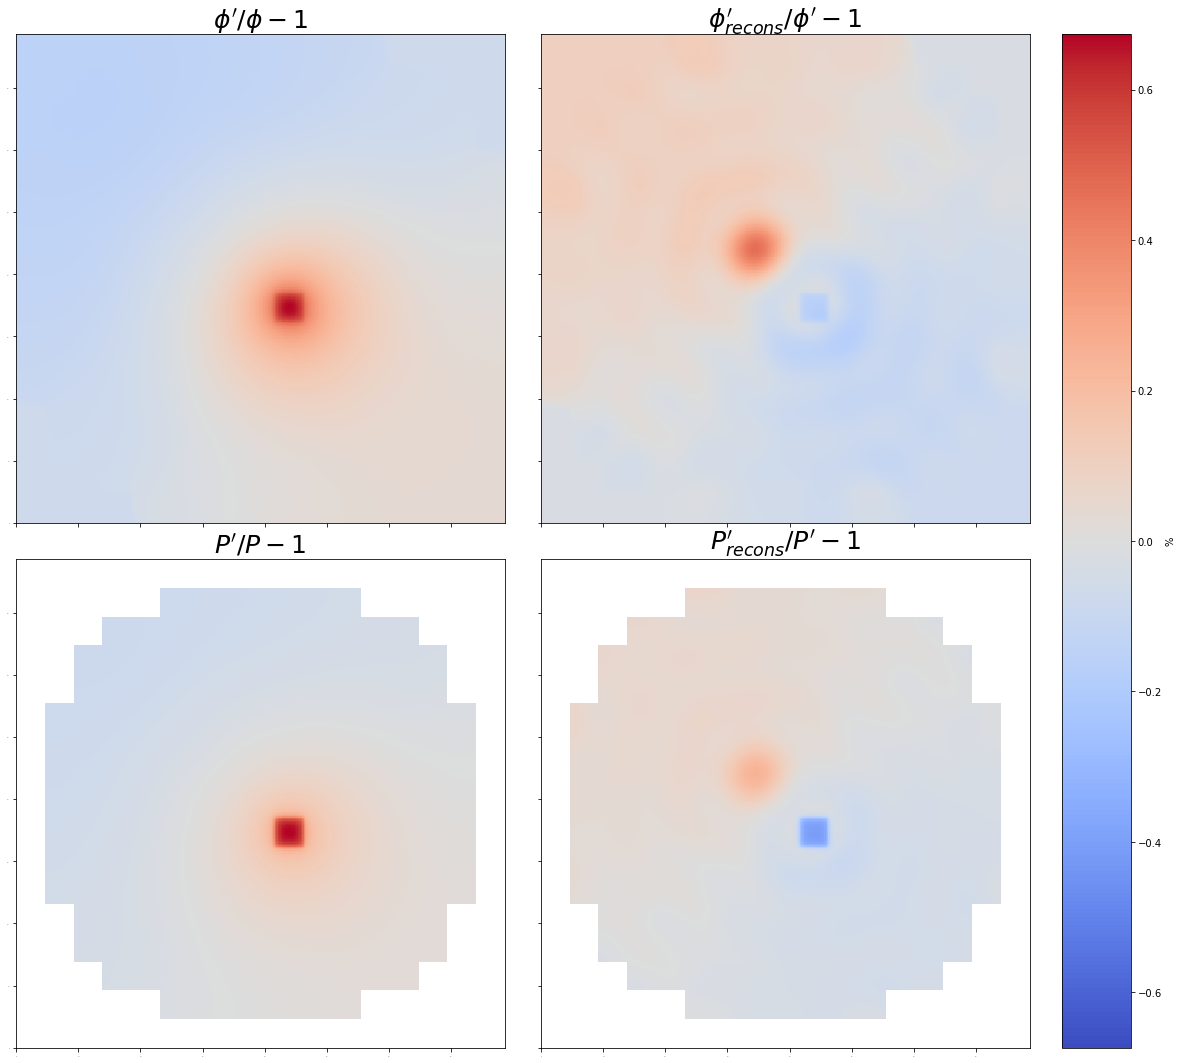

time: 41.1 s (started: 2022-11-24 09:13:48 +01:00)


In [30]:
fuel1 = [[1.4360, 0.0095042, 0.0058708, 1, 0., 0.017754*1.01, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.3635, 0.0750058, 0.0960670, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel1, "fuel1_pert_sigr", reac_names)

x = [0, 17 * 23.1226]
y = [0, 17 * 23.1226]


pblm = np.array([["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1_pert_sigr", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel1", "fuel5", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel5", "fuel1", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel1", "fuel6", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel6", "fuel1", "fuel3", "refl"],  
                 ["refl",  "fuel3", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel5", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel3", "refl"],  
                 ["refl",  "refl",  "fuel3", "fuel4", "fuel2", "fuel7", "fuel2", "fuel7", "fuel1", "fuel7", "fuel2", "fuel7", "fuel2", "fuel4", "fuel3", "refl",  "refl"],  
                 ["void",  "refl",  "fuel3", "fuel3", "fuel4", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel6", "fuel1", "fuel4", "fuel3", "fuel3", "refl",  "void"], 
                 ["void",  "refl",  "refl",  "fuel3", "fuel3", "fuel7", "fuel1", "fuel1", "fuel1", "fuel1", "fuel1", "fuel7", "fuel3", "fuel3", "refl",  "refl",  "void"], 
                 ["void",  "void",  "refl",  "refl",  "refl",  "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "fuel3", "refl",  "refl",  "refl",  "void",  "void"], 
                 ["void",  "void",  "void",  "void",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "refl",  "void",  "void",  "void",  "void"]])
# print(pblm)

#we mesh it 
nb_div_pmat_x = 20
nb_div_pmat_y = 20
shape = (pblm.shape[0]*nb_div_pmat_y, pblm.shape[1]*nb_div_pmat_x)
geom = np.empty(shape, dtype='U16')
for i, row in enumerate(pblm):
    for j, value in enumerate(row):
        geom[i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
             nb_div_pmat_x:(j+1)*nb_div_pmat_x] = value

geometry = np.array([geom])

x_mesh = np.linspace(x[0], x[1], geom.shape[1]+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], geom.shape[0]+1)
y_mean = (y_mesh[:-1] + y_mesh[1:])/2.
dy = y_mesh[1:]-y_mesh[:-1]

macrolib_pert = mat.Macrolib(mat_lib, geometry)

s_pert_fuel_scatt = solver.SolverFullSlepc(x_mesh, y_mesh,
                                macrolib_pert, 0., 0., 0., 0.)
s_pert_fuel_scatt.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel_scatt = solver.SolverFullSlepc(s_pert_fuel_scatt)

_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel_scatt, "PhiStarMPhi")

(delta_scatt_ass, delta_recons_scatt_ass, re_scatt_ass,
            delta_power_scatt_ass, delta_recons_power_scatt_ass, re_power_scatt_ass) = plot_delta(s, s_recons_fuel_scatt, s_pert_fuel_scatt)

0.002 & 0.576 & 0.010& 0.580 & 0.103 & 0.618 & 0.203 \\ \hline
0.002 & 0.532 & 0.009 & 0.573  & 0.055 & 0.570 & 0.007 \\ \hline
--------------------------------------------------
0.073 & 0.513 & 0.186& 0.502 & 0.509 & 0.694 & 0.871 \\ \hline


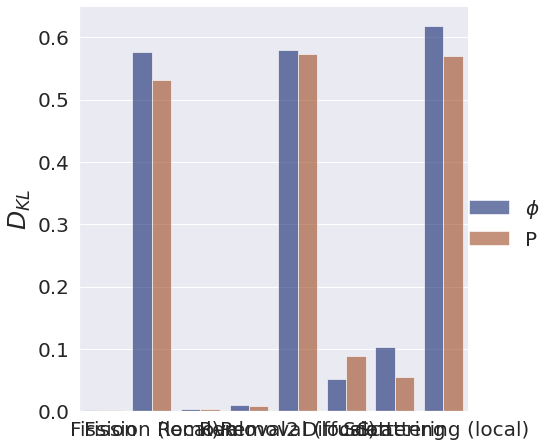

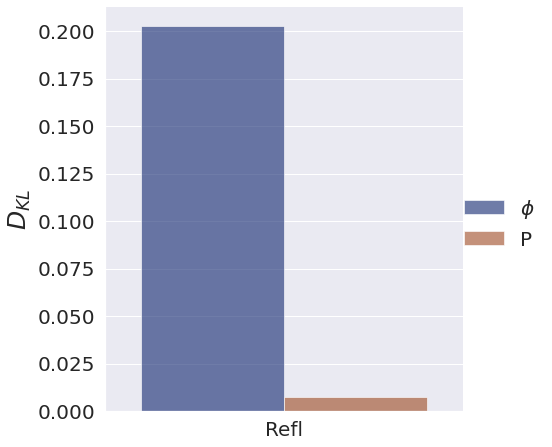

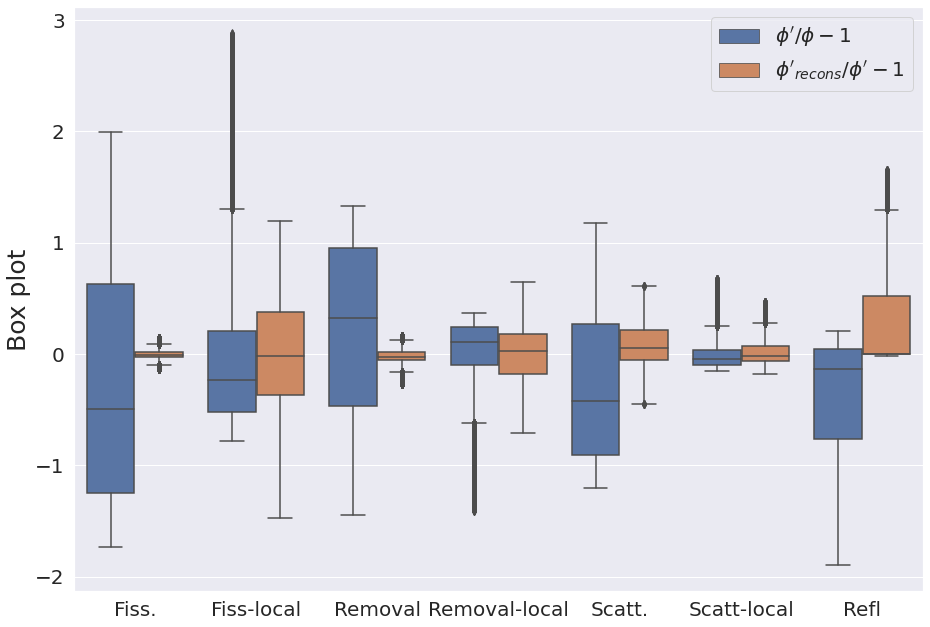

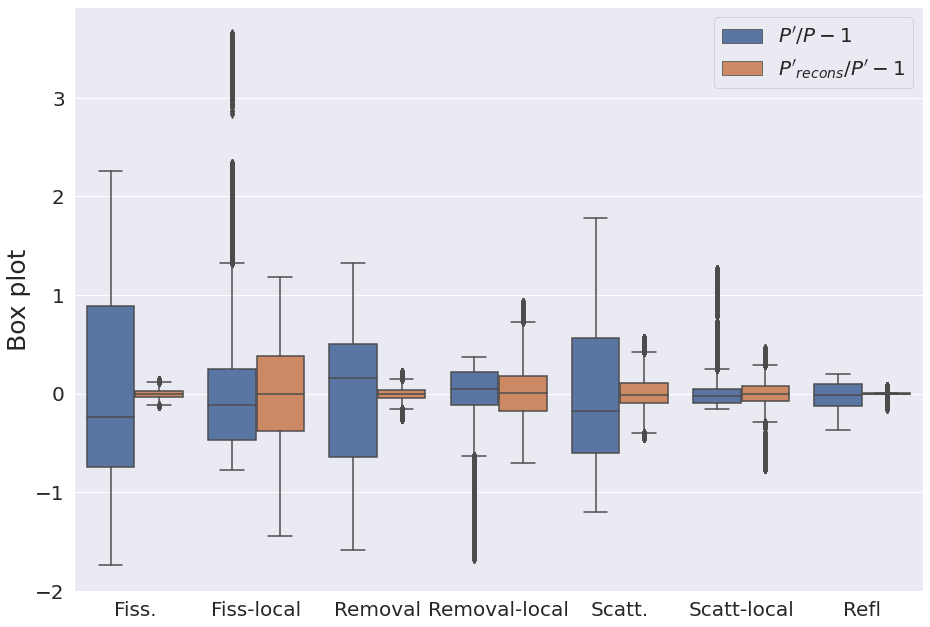

time: 14.2 s (started: 2022-11-24 09:14:43 +01:00)


In [31]:
print(f"{re_sigf:.3f} & {re_sigf_ass:.3f} & {re_removal2:.3f}& {re_sigr_ass:.3f} & {re_scatt:.3f} & {re_scatt_ass:.3f} & {re_refl:.3f} \\\ \hline")
print(f"{re_power_sigf:.3f} & {re_power_sigf_ass:.3f} & {re_power_removal2:.3f} & {re_power_sigr_ass:.3f}  & {re_power_scatt:.3f} & {re_power_scatt_ass:.3f} & {re_power_refl:.3f} \\\ \hline")

print("--------------------------------------------------")

print(f"{np.max(np.abs(delta_recons_sigf))/np.max(np.abs(delta_sigf)):.3f} & {np.max(np.abs(delta_recons_sigf_ass))/np.max(np.abs(delta_sigf_ass)):.3f} & {np.max(np.abs(delta_recons_removal2))/np.max(np.abs(delta_removal2)):.3f}& {np.max(np.abs(delta_recons_sigr_ass))/np.max(np.abs(delta_sigr_ass)):.3f} & {np.max(np.abs(delta_recons_scatt))/np.max(np.abs(delta_scatt)):.3f} & {np.max(np.abs(delta_recons_scatt_ass))/np.max(np.abs(delta_scatt_ass)):.3f} & {np.max(np.abs(delta_recons_refl))/np.max(np.abs(delta_refl)):.3f} \\\ \hline")


SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 29

sns.set(rc={'figure.figsize':(11.7*1.3, 8.27*1.3),
             "font.size": SMALL_SIZE, "axes.titlesize": SMALL_SIZE, "axes.labelsize": MEDIUM_SIZE,
             "xtick.labelsize": SMALL_SIZE, "ytick.labelsize": SMALL_SIZE,
             "legend.fontsize": SMALL_SIZE, "figure.titlesize": BIGGER_SIZE})

iterables = [["Fission", "Fission (local)", "Removal", "Removal2", "Removal (local)", "Diffusion", "Scattering", "Scattering (local)"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_sigf, re_power_sigf,
                     re_sigf_ass, re_power_sigf_ass,
                     re_sigr, re_power_sigr,
                     re_removal2, re_power_removal2,
                     re_sigr_ass, re_power_sigr_ass,
                     re_D, re_power_D,
                     re_scatt, re_power_scatt,
                     re_scatt_ass, re_power_scatt_ass],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()


iterables = [["Refl"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_refl, re_power_refl],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()
ax.set(xlabel=None)
plt.show()
             
iterables = [["Fiss.", "Fiss-local", "Removal",  "Removal-local", "Scatt.", "Scatt-local", "Refl"], ["$\phi'/\phi -1$", "$\phi'_{recons}/\phi' -1$"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])

data = pd.DataFrame([delta_sigf.flatten()/3., delta_recons_sigf.flatten()/3.,
                     delta_sigf_ass.flatten(), delta_recons_sigf_ass.flatten(),
                     delta_removal2.flatten()/4., delta_recons_removal2.flatten()/4.,
                     delta_sigr_ass.flatten()/2., delta_recons_sigr_ass.flatten()/2.,
                     delta_scatt.flatten(), delta_recons_scatt.flatten(),
                     delta_scatt_ass.flatten(), delta_recons_scatt_ass.flatten(),
                     delta_refl.flatten(), delta_recons_refl.flatten()],
                     index=index)
data = data.unstack([0, 1]).to_frame().reset_index([-1, -2])
data.columns = ["Case", "", "Box plot"]

iterables = [["Fiss.", "Fiss-local", "Removal",  "Removal-local", "Scatt.", "Scatt-local", "Refl"], ["$P'/P -1$", "$P'_{recons}/P' -1$"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
data_power = pd.DataFrame([delta_power_sigf.flatten()/3., delta_recons_power_sigf.flatten()/3.,
                           delta_power_sigf_ass.flatten(), delta_recons_power_sigf_ass.flatten(),
                           delta_power_removal2.flatten()/4., delta_recons_power_removal2.flatten()/4.,
                           delta_power_sigr_ass.flatten()/2., delta_recons_power_sigr_ass.flatten()/2.,
                           delta_power_scatt.flatten(), delta_recons_power_scatt.flatten(),
                           delta_power_scatt_ass.flatten(), delta_recons_power_scatt_ass.flatten(),
                           delta_power_refl.flatten(), delta_recons_power_refl.flatten()],
                           index=index)
data_power = data_power.unstack([0, 1]).to_frame().reset_index([-1, -2])
data_power.columns = ["Case", "", "Box plot"]


ax = sns.boxplot(data=data, x="Case", y="Box plot", hue="")
ax.set(xlabel=None)
plt.show()

ax = sns.boxplot(data=data_power, x="Case", y="Box plot", hue="")
ax.set(xlabel=None)
plt.show()

